In [1]:
import pandas as pd
print(pd.__version__)


2.0.3


In [2]:
import warnings
warnings.filterwarnings('ignore')
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
sys.path.append('./../src/')
import dill
import random
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

import utils
from utils import id_to_name
import pickle

random.seed(9)
np.random.seed(9)

date = "sep2024"
atleast = 2
with open(f"uberon_{date}_atleast{atleast}", "rb") as dill_file:
    subtree, subtree_meta, pos = dill.load(dill_file)
mlb=MultiLabelBinarizer().fit([[id_to_name[node] for node in subtree.nodes]])
import plotly.graph_objs as go

In [3]:
atleast = thresh = 2

Mv_all, meta_all, mapping_all = dill.load(open(f'./../data/GEO/preprocessed/450K_Mvalues_atleast{atleast}_samplewise', 'rb'))
print(Mv_all.shape)
meta_multi = utils.propagate_parent(subtree, meta_all, outdict=False)
meta_mlb = mlb.transform(meta_multi['tissue_name'].values)

load_name = f"./../data/GEO/minipatch/minipatch_whole_frequencies"
selection_freq = dill.load(open(load_name, 'rb'))
selection_freq = pd.DataFrame(selection_freq, index=Mv_all.columns)

with open(f"./../data/GEO/minipatch/multilabel_whole_clf", 'rb') as f:
    clf = pickle.load(f)

# tissue_to_clf45 = {t:c for t,c in zip(mlb.classes_, clf45.estimators_)}

mapping_all['chr_num'] = mapping_all['chr'].str.extract('(\d+)').astype(int)
mapping_all = mapping_all.sort_values(by=['chr_num','position'])

(2604, 473821)


In [4]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC

selection_frequency_threshold = 0.57

minipatch_probes = list(selection_freq[selection_freq[0]>=selection_frequency_threshold].index)
Mv_minipatch = Mv_all[minipatch_probes]
print(Mv_minipatch.shape)

# clf45 = MultiOutputClassifier(SVC(class_weight='balanced', kernel='linear', random_state=9, probability=True))
# clf45.fit(Mv45, meta_mlb)

(2604, 1050)


# functions

In [5]:
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import networkx as nx
import matplotlib.pyplot as plt
from utils import id_to_name

def combine_qualitative_cmaps(cmap1, cmap2):
    # Get the colors from both colormaps
    colors1 = cmap1.colors
    colors2 = cmap2.colors

    # Combine the colors
    combined_colors = colors1 + colors2

    # Create and return a new qualitative colormap
    return plt.cm.colors.ListedColormap(combined_colors)

def generate_colors(n):
    # cmap = plt.get_cmap('rainbow')
    # cmap = plt.get_cmap('gist_rainbow')
    # cmap = plt.get_cmap('gist_ncar')
    # cmap = plt.get_cmap('hsv')
    # cmap = plt.get_cmap('nipy_spectral')
    cmap1 = plt.get_cmap('Set1')
    cmap2 = plt.get_cmap('Set2')
    # combine them and build a new colormap
    cmap = combine_qualitative_cmaps(cmap1, cmap2)
    # rgba_colors = cmap(np.linspace(0, 1, n))
    rgba_colors = cmap.colors[:n]
    hex_colors = [mcolors.to_hex(color) for color in rgba_colors]
    
    # hex_colors = [
    #     '#e6194B', '#3cb44b', '#ffe119', '#4363d8', 
    #     '#f58231', '#911eb4', '#42d4f4', 
    #     '#f032e6', '#bfef45', '#fabed4', 
    #     '#469990', '#dcbeff', '#9A6324', 
    #     '#fffac8', '#800000', '#aaffc3', 
    #     '#808000', '#ffd8b1', '#000075', 
    #     '#a9a9a9', '#ffffff', '#000000'
    # ]
    
    hex_colors = [
    "#e6194b", "#3cb44b", "#ffe119", "#4363d8", "#f58231",
    "#911eb4", "#46f0f0", "#bcf60c",  "#800000",
    "#008080",  "#e6beff", "#f032e6", "#fabebe", "#9a6324", "#fffac8",
    "#aaffc3", "#808000", "#ffd8b1", "#000075", "#808080"
    ]

    return hex_colors

def generate_gradient_colors(base_color, n):
    base_rgb = mcolors.hex2color(base_color)
    r, g, b = base_rgb

    gradients = []
    buffer = 4
    # n = n+buffer
    for i in range(n):
        factor = i / (n) if n > 1 else 0.0
        gradient_color = (r + (1 - r) * factor, g + (1 - g) * factor, b + (1 - b) * factor)
        # gradient_color = (r * factor, g * factor, b * factor)
        # if i>(buffer-1): gradients.append(gradient_color)
        gradients.append(gradient_color)

    return gradients

def show_color_dots(colors):
    num_colors = len(colors)

    # Create a scatter plot with colored dots
    fig, ax = plt.subplots(figsize=(8, 1))
    ax.scatter(range(num_colors), [1] * num_colors, color=colors, s=1000)

    # Hide axes and labels
    ax.axis('off')

    plt.show()

def get_family_colors(subtree, display=False):
    '''
    uses generate_colors(), generate_gradient_colors()
    '''
    families = [list(x) for x in nx.weakly_connected_components(subtree)]
    families.sort(key=len, reverse=True)
    colors = generate_colors(len(families))
    print(colors)
    ordered = list()
    member_color = dict()
    for i, family in enumerate(families):
        member_children = {id_to_name[member]: [id_to_name[x] for x in nx.ancestors(subtree, member)] for member in family}
        
        head = max(member_children, key=lambda k: len(member_children[k]))
        family_tree = subtree.subgraph(family)
        # nx.draw(family_tree, with_labels=True
        family_ordered = list(reversed(list(nx.topological_sort(family_tree))))
        gradient_colors = generate_gradient_colors(colors[i], len(family))
        # print(gradient_colors)
        
        if display:
            show_color_dots(gradient_colors)
                                                                                
        member_color.update({id_to_name[member]:gradient_colors[j] for j, member in enumerate(family_ordered)})
        ordered.extend([id_to_name[member] for member in family_ordered])
        
    return member_color, ordered

colors, ordered = get_family_colors(subtree, display=False)

['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#bcf60c', '#800000', '#008080', '#e6beff', '#f032e6', '#fabebe', '#9a6324', '#fffac8', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080']


In [6]:
def get_TCGA_data(num_samples, cancer_name, scale=True):
    '''
    grab, convert, scale, impute TCGA data
    '''
    cancer_beta = pd.read_csv(f'/grain/mk98/methyl/methylation-classification/data/TCGA/compiled/TCGA-{cancer_name}_beta_{num_samples}.txt.gz', header=0, sep='\t', index_col=0)
    cancer_Mv = np.log2(cancer_beta/ (1 - cancer_beta)).T
    cancer_meta = pd.read_csv(f'/grain/mk98/methyl/methylation-classification/data/TCGA/compiled/TCGA-{cancer_name}_meta_{num_samples}.txt.gz', header=0, sep='\t', index_col=0)
    cancer_meta = cancer_meta.set_index('barcode')
    if scale:
        scaler = StandardScaler()
        cancer_Mv = pd.DataFrame(scaler.fit_transform(cancer_Mv.T.values).T, index=cancer_Mv.index, columns=cancer_Mv.columns)
    return cancer_Mv, cancer_meta

In [7]:
def predict_and_report_TCGA(cancer_minipatch, cancer_meta, clf, cancer_tissue='breast'):
    '''
    predict and report performance on TCGA data
    '''
    
    # pred = clf.predict(cancer_minipatch.fillna(0))
    pred = clf.predict(cancer_minipatch)
    pred_name = pd.Series(mlb.inverse_transform(pred), index=cancer_meta.index)
    
    pred_proba = np.transpose([y_pred[:, 1] for y_pred in clf.predict_proba(cancer_minipatch)])
    pred_proba_df = pd.DataFrame(pred_proba, columns=mlb.classes_, index=cancer_meta.index)

    pred = pd.DataFrame(pred, index=cancer_meta.index)
    true = pd.DataFrame(mlb.transform([[cancer_tissue]]*len(pred)), index=cancer_meta.index)
    
    print(f"true distribution: {cancer_meta['sample_type'].value_counts()}")
    print()
    
    print(f"overall accuracy: {accuracy_score(pred.values, true)}")
    [print(f"{sample_type} accuracy: {accuracy_score(pred.loc[result.index].values, true.loc[result.index].values)}") for sample_type, result in cancer_meta.groupby('sample_type')]
    print()
    
    print(f"overall precision for {cancer_tissue}: {precision_score(pred.values, true, average=None)[list(mlb.classes_).index(cancer_tissue)]}")
    [print(f"{sample_type} precision: {precision_score(pred.loc[result.index].values, true.loc[result.index].values, average=None)[list(mlb.classes_).index(cancer_tissue)]}") for sample_type, result in cancer_meta.groupby('sample_type')]
    print()
    
    print(f"overall sample precision for {cancer_tissue}: {precision_score(pred.values, true, average='samples')}")
    [print(f"{sample_type} precision: {precision_score(pred.loc[result.index].values, true.loc[result.index].values, average='samples')}") for sample_type, result in cancer_meta.groupby('sample_type')]

    
    return pred_name, pred_proba_df

In [8]:
from sklearn.preprocessing import StandardScaler
def scale(cancer_Mv):
    scaler = StandardScaler()
    cancer_Mv = pd.DataFrame(scaler.fit_transform(cancer_Mv.T).T, index=cancer_Mv.index, columns=cancer_Mv.columns)
    return cancer_Mv

In [9]:
def summarize_predicted_labels(pred_name, cancer_meta, cancer_name, display=True):
    expanded_pred_name = pred_name.explode()
    merged_df = expanded_pred_name.to_frame('tissue').merge(cancer_meta, left_index=True, right_index=True)
    summary = merged_df.groupby(['sample_type', 'tissue']).size().unstack(fill_value=0)
    
    normalized_summary = summary.div(summary.sum(axis=1), axis=0).loc[[x for x in ['Solid Tissue Normal', 'Primary Tumor', 'Metastatic', 'Recurrent Tumor'] if x in summary.index]]
    existing_ordered = [x for x in ordered if x in normalized_summary.columns]
    normalized_summary = normalized_summary[existing_ordered]
    
    if display:
        # Visualization 1: Stacked Bar Plot with Custom Colors
        normalized_summary.plot(
            kind='bar', 
            stacked=True, 
            color=[colors[label] for label in existing_ordered], 
            figsize=(15, 7)
        )
        plt.title(f'{cancer_name}: Normalized Tissue Distribution by Sample Type')
        plt.ylabel('Proportion')
        plt.xlabel('Sample Type')
        plt.legend(title='Tissue', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

        # Visualization 2: Heatmap with Custom Colors
        plt.figure(figsize=(7, 10))
        sns.heatmap(
            normalized_summary.T,
            annot=True,
            cmap='viridis',
            linewidths=.5,
            cbar_kws={'label': 'Counts'}
        )
        plt.title(f'{cancer_name}: Heatmap of Predicted Tissue Distribution by Sample Type')
        plt.xlabel('Sample Type')
        plt.ylabel('Predicted Tissue')
        plt.show()
        
        
    return normalized_summary

In [10]:
# def impute_median_of_neighbors(group, wanted_probes, max_distance=1000000):
#     values = group.iloc[:, 2:].T.copy()
    
#     for probe in wanted_probes:
#         if probe in values.columns:
#             idx = values.columns.get_loc(probe)
#             probe_positions = group['pos'].values
#             current_pos = probe_positions[idx]
            
#             for i in range(len(values)):
#                 if pd.isna(values.iloc[i, idx]):
#                     # Find neighbors within max_distance
#                     distance_mask = abs(probe_positions - current_pos) <= max_distance
                    
#                     # Get indices of valid neighbors
#                     valid_indices = np.where(distance_mask)[0]
                    
#                     # Limit to 5 neighbors on each side
#                     center_idx = np.where(valid_indices == idx)[0][0]
#                     start = max(0, center_idx - 5)
#                     end = min(len(valid_indices), center_idx + 6)
#                     neighbor_indices = valid_indices[start:end]
                    
#                     # Calculate median of selected neighbors
#                     neighbors = values.iloc[i, neighbor_indices]
#                     median_neighbors = neighbors.median()
                    
#                     if not pd.isna(median_neighbors):
#                         values.iloc[i, idx] = median_neighbors
#                     else:
#                         # Fallback to the median of the sample (row-wise)
#                         sample_median = values.iloc[i, :].median()
#                         values.iloc[i, idx] = sample_median
    
#     return values.T

# def impute_chromosome_neighbors(position_df, Mv_df, probes):
#     merged_df = position_df[['chr','position']].join(Mv_df.T)
#     print(merged_df.shape)
#     # print('TCGA-AQ-A0Y5-01A-11D-A14N-05' in merged_df.columns)
#     # merged_df['chr_num'] = merged_df['chr'].str.extract('(\d+)').astype(int)
#     merged_df_sorted = merged_df.sort_values(by=['chr', 'position'])
    
#     imputed_values = merged_df_sorted.groupby('chr').apply(impute_median_of_neighbors, probes)
#     # imputed_values.drop(columns=['chr_num'])
#     print(imputed_values.shape)

#     imputed_values.index = imputed_values.index.droplevel('chr')
    
#     print(imputed_values.shape)
    
#     return imputed_values.loc[probes].T


In [11]:
def impute_median_of_neighbors(group, wanted_probes, max_distance=24000):
    values = group.iloc[:, 2:].T.copy()
    probe_positions = group['position'].values

    for probe in wanted_probes:
        if probe not in values.columns:
            continue

        probe_idx = values.columns.get_loc(probe)
        current_pos = probe_positions[probe_idx]

        for sample_idx in range(len(values)):
            if pd.isna(values.iloc[sample_idx, probe_idx]):
                imputed_value = get_imputed_value(values, probe_positions, sample_idx, probe_idx, current_pos, max_distance)
                values.iloc[sample_idx, probe_idx] = imputed_value

    return values.T

def get_imputed_value(values, probe_positions, sample_idx, probe_idx, current_pos, max_distance):
    distance_mask = abs(probe_positions - current_pos) <= max_distance
    valid_indices = np.where(distance_mask)[0]

    center_idx = np.where(valid_indices == probe_idx)[0][0]
    start = max(0, center_idx - 5)
    end = min(len(valid_indices), center_idx + 6)
    neighbor_indices = valid_indices[start:end]

    neighbors = values.iloc[sample_idx, neighbor_indices]
    median_neighbors = neighbors.median()

    return median_neighbors if not pd.isna(median_neighbors) else values.iloc[sample_idx, :].median()

def impute_chromosome_neighbors(position_df, Mv_df, probes):
    merged_df = position_df[['chr', 'position']].join(Mv_df.T)
    print(merged_df.shape)

    merged_df_sorted = merged_df.sort_values(by=['chr', 'position'])
    imputed_values = merged_df_sorted.groupby('chr').apply(impute_median_of_neighbors, probes)
    print(imputed_values.shape)

    imputed_values.index = imputed_values.index.droplevel('chr')
    print(imputed_values.shape)

    return imputed_values.loc[probes].T


In [12]:
# def get_normal_to_tumor(cancer_Mv, cancer_meta):
#     cancer_patient_paired = []
#     [cancer_patient_paired.extend(patient_data.index) for patient, patient_data in cancer_meta.groupby('patient') if (patient_data.shape[0]==2) and (set(patient_data['sample_type'].unique())==set(['Solid Tissue Normal', 'Primary Tumor']))]
#     cancer_meta_paired = cancer_meta.loc[cancer_patient_paired]
#     cancer_Mv_paired = cancer_Mv.loc[cancer_patient_paired]
    
#     return cancer_Mv_paired, cancer_meta_paired

# def visualize_paired(cancer_pred_name_paired, cancer_meta_paired, cancer_type):
#     cancer_meta_paired = cancer_meta_paired.reset_index()
    
#     # Step 1: Filter the data for "Solid Tissue Normal" and "Primary Tumor"
#     solid_tissue_normal = cancer_meta_paired[cancer_meta_paired['sample_type'] == "Solid Tissue Normal"]
#     primary_tumor = cancer_meta_paired[cancer_meta_paired['sample_type'] == "Primary Tumor"]

#     # Step 2: Pair the samples by patient ID
#     paired_samples = solid_tissue_normal.merge(primary_tumor, on='patient', suffixes=('_normal', '_tumor'))

#     # Step 3: Compare predictions
#     changes_summary = []

#     for _, row in paired_samples.iterrows():
#         normal_sample = row['barcode_normal']
#         tumor_sample = row['barcode_tumor']

#         normal_pred = set(cancer_pred_name_paired[normal_sample])
#         tumor_pred = set(cancer_pred_name_paired[tumor_sample])

#         added = tumor_pred - normal_pred
#         removed = normal_pred - tumor_pred

#         changes_summary.append({
#             'patient': row['patient'],
#             'normal_pred': normal_pred,
#             'tumor_pred': tumor_pred,
#             'added': added,
#             'removed': removed
#         })

#     changes_df = pd.DataFrame(changes_summary)
    
#     # Convert sets to tuples to make them hashable
#     changes_df['added'] = changes_df['added'].apply(tuple)
#     changes_df['removed'] = changes_df['removed'].apply(tuple)
    
#     # Prepare data for the bar chart
#     added_expanded = changes_df[['patient', 'added']].explode('added')
#     removed_expanded = changes_df[['patient', 'removed']].explode('removed')

#     # Count occurrences of added and removed tissues
#     added_counts = added_expanded['added'].value_counts().sort_index()
#     removed_counts = removed_expanded['removed'].value_counts().sort_index()

#     # Combine into a single DataFrame
#     summary_df = pd.DataFrame({
#         'Added': added_counts,
#         'Removed': removed_counts
#     }).fillna(0)

#     # Plot the bar chart
#     summary_df.plot(kind='bar', stacked=False, color=['#1f77b4', '#ff7f0e'], figsize=(12, 7))

#     plt.title(f'{cancer_type}: Frequency of Added and Removed Tissue Predictions between Solid Tissue Normal to Primary Tumor')
#     plt.xlabel('Tissue Type')
#     plt.ylabel('Frequency')
#     plt.xticks(rotation=45, ha='right')
#     plt.legend(title='Change Type')
#     plt.tight_layout()
#     plt.show()


In [13]:
# import pandas as pd
# import plotly.graph_objects as go
# import plotly.io as pio

# def visualize_sankey_with_no_predictions(cancer_pred_name_paired, cancer_meta_paired, output_file='sankey_diagram.html'):
#     # Filter the data for "Solid Tissue Normal" and "Primary Tumor"
#     cancer_meta_paired = cancer_meta_paired.reset_index()
#     solid_tissue_normal = cancer_meta_paired[cancer_meta_paired['sample_type'] == "Solid Tissue Normal"]
#     primary_tumor = cancer_meta_paired[cancer_meta_paired['sample_type'] == "Primary Tumor"]

#     # Pair the samples by patient ID
#     paired_samples = solid_tissue_normal.merge(primary_tumor, on='patient', suffixes=('_normal', '_tumor'))

#     # Collect all possible tissue predictions including "no prediction"
#     left_nodes = ['no prediction']
#     right_nodes = ['no prediction']
#     left_node_map = {'no prediction': 0}
#     right_node_map = {'no prediction': 0}

#     # Extract predictions
#     for _, row in paired_samples.iterrows():
#         normal_preds = tuple(cancer_pred_name_paired.get(row['barcode_normal'], ()))
#         tumor_preds = tuple(cancer_pred_name_paired.get(row['barcode_tumor'], ()))
        
#         if not normal_preds:
#             normal_preds = ('no prediction',)
#         if not tumor_preds:
#             tumor_preds = ('no prediction',)
        
#         # Ensure each prediction has a unique node
#         for pred in normal_preds:
#             if pred not in left_node_map:
#                 index = len(left_nodes)
#                 left_node_map[pred] = index
#                 left_nodes.append(pred)

#         for pred in tumor_preds:
#             if pred not in right_node_map:
#                 index = len(right_nodes)
#                 right_node_map[pred] = index
#                 right_nodes.append(pred)

#     # Create nodes for Sankey diagram
#     nodes = left_nodes + right_nodes
#     node_indices = {node: idx for idx, node in enumerate(nodes)}

#     # Create links
#     links = []
#     for _, row in paired_samples.iterrows():
#         normal_preds = tuple(cancer_pred_name_paired.get(row['barcode_normal'], ()))
#         tumor_preds = tuple(cancer_pred_name_paired.get(row['barcode_tumor'], ()))
        
#         if not normal_preds:
#             normal_preds = ('no prediction',)
#         if not tumor_preds:
#             tumor_preds = ('no prediction',)
        
#         for pred in normal_preds:
#             for tumor_pred in tumor_preds:
#                 links.append({
#                     'source': left_node_map[pred],
#                     'target': right_node_map[tumor_pred] + len(left_nodes),
#                     'value': 1
#                 })

#     # Prepare the Sankey diagram
#     fig = go.Figure(data=[go.Sankey(
#         node=dict(
#             pad=15,
#             thickness=20,
#             line=dict(color="black", width=0.5),
#             label=nodes,
#             x=[0.1] * len(left_nodes) + [0.9] * len(right_nodes)  # x positions for alignment
#         ),
#         link=dict(
#             source=[link['source'] for link in links],
#             target=[link['target'] for link in links],
#             value=[link['value'] for link in links]
#         )
#     )])

#     fig.update_layout(
#         title_text='Sankey Diagram of Tissue Prediction Transitions (Including No Predictions)',
#         font_size=10
#     )

#     # Save the plot as an HTML file
#     pio.write_html(fig, file=output_file, auto_open=True)

In [14]:
def plot_by_purity(cancer_pred_name, cancer_meta, purity, cancer_type):
    cancer_purity = purity[purity['Cancer type']==cancer_type].rename_axis('sample')
    cancer_meta_reset = cancer_meta.reset_index()
    cancer_meta_purity = pd.merge(cancer_meta_reset, cancer_purity['ESTIMATE'], on='sample', how='left')  # 'inner' for only matching IDs
    
    cancer_meta_purity = cancer_meta_purity.set_index('barcode')
    existing_purity = [x for x in cancer_pred_name.index if x in cancer_meta_purity.index]
    print(f"{len(existing_purity)} samples have purity info")

    # Combine the purity data with the prediction data
    df = pd.DataFrame({
        'Purity': cancer_meta_purity.loc[existing_purity]['ESTIMATE'],
        'Prediction': cancer_pred_name.loc[existing_purity]
    })
    
    
    # Define bin edges and labels
    bin_edges = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    bin_labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0']

    # Drop rows with NaN in Prediction and explode the Prediction column
    df_exploded = df.dropna(subset=['Prediction']).explode('Prediction')

    # Bin the Purity levels
    df_exploded['Purity_Binned'] = pd.cut(df_exploded['Purity'], bins=bin_edges, labels=bin_labels, right=False)

    # Group by binned Purity and Prediction to get counts
    label_counts_by_purity = df_exploded.groupby(['Purity_Binned', 'Prediction']).size().reset_index(name='Count')

    # Pivot the data to have binned purity levels as rows and tissues as columns
    pivot_df = label_counts_by_purity.pivot(index='Purity_Binned', columns='Prediction', values='Count').fillna(0)

    # Normalize the counts to proportions
    pivot_df_normalized = pivot_df.div(pivot_df.sum(axis=1), axis=0)

    # Plot the stacked bar chart with normalized data
    colors_list = [colors.get(label, '#000000') for label in pivot_df_normalized.columns]
    pivot_df_normalized.plot(kind='bar', stacked=True, figsize=(14, 8), color=colors_list)

    # Set plot labels and title
    plt.xlabel('Purity Level')
    plt.ylabel('Proportion')
    plt.title(f'{cancer_type}: Distribution of Tissues Across Binned Purity Levels (Normalized)')
    plt.legend(title='Tissue Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Show plot
    plt.show()

In [15]:
def plot_predicted_labels_vs_purity(cancer_pred_name, cancer_meta, cancer_purity, cancer_name):
    """
    Creates a scatter plot of the number of predicted labels against purity values.

    Parameters:
    cancer_pred_name (pd.Series): barcode (index) -> tuple of predictions
    cancer_meta (pd.DataFrame): barcode (index) -> sample_id
    cancer_purity (pd.Series): sample_id (index) -> purity value
    """
    # Merge the data based on barcode and sample_id
    merged_data = pd.merge(
        pd.DataFrame(cancer_pred_name.index, columns=['barcode']),
        pd.DataFrame(cancer_pred_name.values, columns=['predictions']),
        left_index=True,
        right_index=True
    ).merge(
        pd.DataFrame(cancer_meta['sample'].values, columns=['sample_id'], index=cancer_meta['sample'].index),
        left_on='barcode',
        right_index=True
    ).merge(
        pd.DataFrame(cancer_purity.values, columns=['purity'], index=cancer_purity.index),
        left_on='sample_id',
        right_index=True
    )

    # Calculate the number of predicted labels
    merged_data['num_labels'] = merged_data['predictions'].apply(len)

    # Create the scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(merged_data['purity'], merged_data['num_labels'])
    plt.xlabel('Purity')
    plt.ylabel('Number of Predicted Labels')
    plt.title(f'{cancer_name}: Scatter Plot of Predicted Labels vs. Purity')
    plt.show()


In [16]:
import pandas as pd
import matplotlib.pyplot as plt

def create_plot(cancer_pred_name, cancer_meta, cancer_purity, cancer_name, ax=None):
    """
    Creates a scatter plot of predicted labels vs. purity.

    Parameters:
    - cancer_pred_name (pd.Series): barcode (index) -> tuple of predictions
    - cancer_meta (pd.DataFrame): barcode (index) -> sample_id
    - cancer_purity (pd.Series): sample_id (index) -> purity value
    - cancer_name (str): The name of the cancer type
    - ax (matplotlib.axes.Axes, optional): The axes to plot on. If None, a new plot is created.

    Returns:
    - matplotlib.axes.Axes: The axes with the plot.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Merge and process data
    merged_data = (
        pd.merge(
            pd.DataFrame(cancer_pred_name.index, columns=['barcode']),
            pd.DataFrame(cancer_pred_name.values, columns=['predictions']),
            left_index=True,
            right_index=True
        )
        .merge(
            pd.DataFrame(cancer_meta['sample'].values, columns=['sample_id'], index=cancer_meta['sample'].index),
            left_on='barcode',
            right_index=True
        )
        .merge(
            pd.DataFrame(cancer_purity.values, columns=['purity'], index=cancer_purity.index),
            left_on='sample_id',
            right_index=True
        )
    )
    merged_data['num_labels'] = merged_data['predictions'].apply(len)

    # Plot data
    ax.scatter(merged_data['purity'], merged_data['num_labels'], label=cancer_name)
    ax.set_xlabel('Purity')
    ax.set_ylabel('Number of Predicted Labels')
    ax.set_title('Scatter Plot of Predicted Labels vs. Purity')
    # Plot density
    # sns.kdeplot(
    #     data=merged_data,
    #     x='purity',
    #     y='num_labels',
    #     fill=True,
    #     ax=ax,
    #     label=cancer_name
    # )
    
    ax.set_xlabel('Purity')
    ax.set_ylabel('Number of Predicted Labels')
    ax.set_title('Density Plot of Predicted Labels vs. Purity')
    
    return ax

def plot_multiple_cancers(cancer_data):
    """
    Plots multiple cancer types on the same axes.

    Parameters:
    - cancer_data (list of tuples): Each tuple contains (cancer_pred_name, cancer_meta, cancer_purity, cancer_name)
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    for (cancer_pred_name, cancer_meta, cancer_purity, cancer_name) in cancer_data:
        create_plot(cancer_pred_name, cancer_meta, cancer_purity, cancer_name, ax=ax)
    
    ax.legend()
    plt.show()


### scikit-learn impute

In [17]:
# brca_Mv_nan = brca_Mv[minipatch_probes]

# from sklearn.impute import SimpleImputer

# def impute(cancer_Mv, method='knn'):
#     if method=='mean':
#         imputer = SimpleImputer(strategy='mean', keep_empty_features=True)
#     elif method=='median':
#         imputer = SimpleImputer(strategy='median', keep_empty_features=True)
#     elif method=='knn': 
#         imputer = KNNImputer(n_neighbors=10, weights='distance', keep_empty_features=True)
#     else:
#         print("please select from methods")
#         return

#     cancer_Mv = pd.DataFrame(imputer.fit_transform(cancer_Mv.T).T, columns=cancer_Mv.columns, index=cancer_Mv.index)
#     return cancer_Mv

# brca_Mv_imputed = scale(impute(brca_Mv_nan, method='knn'))

# plt.figure()
# plt.hist(scale(brca_Mv_nan).values.flatten(), bins=50)
# plt.title('all with NaNs')
# plt.show()

# plt.figure()
# plt.hist(brca_Mv_imputed.values.flatten(), bins=50)
# plt.title('all with imputed')
# plt.show()

# plt.figure()
# plt.hist(brca_Mv_imputed[brca_Mv_nan.isna()].values.flatten(), bins=50)
# plt.title('imputed only')
# plt.show()

# minipatch_probes_sorted_chr = [x for x in mapping_all.index if x in minipatch_probes]
# mapping_minipatch = mapping_all.loc[minipatch_probes_sorted_chr]

# mapping_minipatch

'src/TCGA_beta-download.R'

### files

In [18]:
estimate = pd.read_csv('./../workspace/ESTIMATE.csv', header=3, index_col='Sample ID')
estimate.head()

,Cancer type,ESTIMATE,ABSOLUTE,LUMP,IHC,CPE,Unnamed: 7
Sample ID,,,,,,,
TCGA-OR-A5J1-01A,ACC,0.9368,NaN,0.9774,0.80,0.9246,NaN
TCGA-OR-A5J2-01A,ACC,0.9175,NaN,0.6174,0.95,0.8985,NaN
TCGA-OR-A5J3-01A,ACC,0.9670,NaN,0.9249,0.80,0.9466,NaN
TCGA-OR-A5J4-01A,ACC,NaN,NaN,0.9199,0.80,0.8660,NaN
TCGA-OR-A5J5-01A,ACC,0.9761,NaN,1.0000,0.80,0.9780,NaN


# TCGA BRCA

In [19]:
cancer_type = 'BRCA'

In [20]:
brca_Mv, brca_meta = get_TCGA_data(895, cancer_type, scale=False)

### impute by median of chromosome position neighbors

In [21]:
brca_Mv_imputed = scale(impute_chromosome_neighbors(mapping_all, brca_Mv, minipatch_probes))

(473821, 897)


(473821, 895)
(473821, 895)


In [22]:
brca_Mv_imputed.shape

(895, 1050)

### predict

In [23]:
from sklearn.metrics import accuracy_score, precision_score

In [24]:
brca_pred_name, brca_pred_proba = predict_and_report_TCGA(brca_Mv_imputed[minipatch_probes], brca_meta, clf, 'breast')

true distribution: sample_type
Primary Tumor          793
Solid Tissue Normal     97
Metastatic               5
Name: count, dtype: int64

overall accuracy: 0.21787709497206703
Metastatic accuracy: 0.0
Primary Tumor accuracy: 0.1235813366960908
Solid Tissue Normal accuracy: 1.0

overall precision for breast: 0.3329608938547486
Metastatic precision: 0.0
Primary Tumor precision: 0.25346784363177804
Solid Tissue Normal precision: 1.0

overall sample precision for breast: 0.3329608938547486
Metastatic precision: 0.0
Primary Tumor precision: 0.25346784363177804
Solid Tissue Normal precision: 1.0


In [25]:
import seaborn as sns

## paired

In [26]:
# brca_Mv_paired, brca_meta_paired = get_normal_to_tumor(brca_Mv_imputed, brca_meta)

# brca_pred_name_paired, brca_pred_proba_paired = predict_and_report_TCGA(brca_Mv_paired[minipatch_probes], brca_meta_paired, clf, 'breast')

# brca_summary_paired = summarize_predicted_labels(brca_pred_name_paired, brca_meta_paired, cancer_type)

# visualize_paired(brca_pred_name_paired, brca_meta_paired, cancer_type)

# brca_diagram_paired = SankeyDiagram(brca_pred_name_paired, brca_meta_paired)
# brca_diagram_paired.create_diagram(f"sankey_{cancer_type}_paired")

# brca_diagram_all = SankeyDiagram(brca_pred_name, brca_meta)
# brca_diagram_all.create_diagram(f"sankey_{cancer_type}_all")

# brca_summary = summarize_predicted_labels(brca_pred_name, brca_meta, cancer_type)

## purity

In [27]:
# plot_by_purity(brca_pred_name_paired, brca_meta_paired, estimate, cancer_type)

# plot_predicted_labels_vs_purity(brca_pred_name, brca_meta, estimate[estimate['Cancer type']=='BRCA']['ESTIMATE'], 'BRCA')

## pred proba

In [28]:
# # Group by patient and check if they have different sample types
# patient_groups = brca_meta.groupby('patient')
# relevant_patients = patient_groups.filter(lambda x: x['sample_type'].nunique() > 1)['patient'].unique()

In [29]:
# def check_if_all_paired(cancer_meta, patient_list):
#     print('function will print if any patient samples are not paired:')
#     cancer_meta_paired = cancer_meta[cancer_meta['patient'].isin(patient_list)]
#     [print(x) for p, x in cancer_meta_paired.groupby('patient') if len(set(x['sample_type'].values))<2]

# check_if_all_paired(brca_meta, relevant_patients)

In [30]:
# brca_meta_paired = brca_meta[brca_meta['patient'].isin(relevant_patients)]
# brca_pred_proba_paired = brca_pred_proba.loc[brca_meta_paired.index]
# brca_pred_name_paired = brca_pred_name.loc[brca_meta_paired.index]

# relevant_barcodes = list(brca_meta_paired.index)

In [31]:
# Function to get sorted list of tuples (column name, value)
def rank_by_value(row):
    return sorted(row.items(), key=lambda x: x[1], reverse=True)

In [32]:
# def paired_patients(cancer_proba, cancer_meta, wanted='proba'):
#     patient_groups = cancer_meta.groupby('patient')
#     relevant_patients = patient_groups.filter(lambda x: x['sample_type'].nunique() > 1)['patient'].unique()
    
#     print('function will print if any patient samples are not paired:')
#     cancer_meta_paired = cancer_meta[cancer_meta['patient'].isin(relevant_patients)]
#     [print(x) for p, x in cancer_meta_paired.groupby('patient') if len(set(x['sample_type'].values))<2]
    
#     if wanted=='patients': return relevant_patients
#     if wanted=='proba': return cancer_proba.loc[cancer_meta_paired.index], cancer_meta_paired

In [33]:
def paired_patients(cancer_proba, cancer_meta, wanted='proba'):
    patient_groups = cancer_meta.groupby('patient')
    
    relevant_patients = patient_groups.filter(lambda x: 
        (x['sample_type'].value_counts() == 1).all() and
        set(x['sample_type'].values) == {'Solid Tissue Normal', 'Primary Tumor'}
    )['patient'].unique()
    
    cancer_meta_paired = cancer_meta[cancer_meta['patient'].isin(relevant_patients)]
    
    if wanted == 'patients':
        return relevant_patients
    if wanted == 'proba':
        return cancer_proba.loc[cancer_meta_paired.index], cancer_meta_paired


In [34]:
def proba_swarmplot(cancer_proba_paired, cancer_meta, wanted_tissue='breast'):
    merged_df = pd.merge(cancer_proba_paired[wanted_tissue].reset_index(), cancer_meta.reset_index(), on='barcode')
    
    import seaborn as sns
    sns.swarmplot(data=merged_df, x='sample_type', order=['Solid Tissue Normal','Primary Tumor'], y=wanted_tissue, hue='sample_type')
    plt.ylabel(f"Prediction probability for '{wanted_tissue}'")
    plt.xlabel("Sample type")

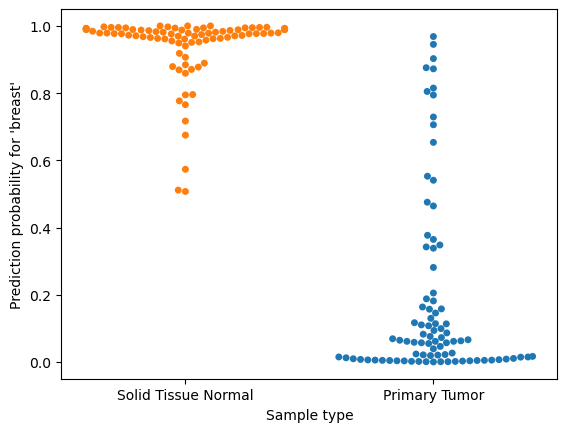

In [35]:
brca_proba_paired, brca_meta_paired = paired_patients(brca_pred_proba, brca_meta)
proba_swarmplot(brca_proba_paired, brca_meta_paired, 'breast')

In [36]:
brca_meta_paired['sample_type'].value_counts()

sample_type
Primary Tumor          87
Solid Tissue Normal    87
Name: count, dtype: int64

In [37]:
def plot_paired_diff(cancer_meta_paired, cancer_proba_paired, cancer_type, stage_column):
    from itertools import combinations
    from scipy.stats import ranksums

    paired_diff = {}
    for patient, group in cancer_meta_paired.groupby('patient'):
        normal = group[group['sample_type'] == 'Solid Tissue Normal'].index[0]
        tumor = group[group['sample_type'] == 'Primary Tumor'].index[0]
        diff = cancer_proba_paired.loc[tumor][cancer_type] - cancer_proba_paired.loc[normal][cancer_type]
        paired_diff[patient] = diff

    paired_diff_df = pd.DataFrame.from_dict(paired_diff, orient='index', columns=[f'{cancer_type}_diff'])

    patient_grade = cancer_meta_paired[cancer_meta_paired['sample_type'] == 'Primary Tumor'].groupby('patient')[stage_column].first()

    plot_data = paired_diff_df.merge(patient_grade, left_index=True, right_index=True)
    plot_data[stage_column] = plot_data[stage_column].fillna('Unknown')

    stages = ["Stage I", "Stage IA", "Stage IB", "Stage II", "Stage IIA", "Stage IIB", 
              "Stage III", "Stage IIIA", "Stage IIIB", "Stage IIIC", "Stage IV", "Unknown"]
    
    if stage_column=="ajcc_pathologic_stage":
        labels=stages
    else:
        labels=sorted(cancer_meta_paired[stage_column].unique())

    def custom_sort(item):
        if item == "Unknown":
            return len(labels)
        return labels.index(item)

    ordered_grades = sorted(plot_data[stage_column].unique(), key=custom_sort)

    plot_data[stage_column] = pd.Categorical(
        plot_data[stage_column],
        categories=ordered_grades,
        ordered=True
    )
    
    # Perform pairwise Wilcoxon rank-sum tests
    stages = plot_data[stage_column].unique()
    results = {}
    
    for stage1, stage2 in combinations(stages, 2):
        stage1_data = plot_data[plot_data[stage_column] == stage1][f'{cancer_type}_diff']
        stage2_data = plot_data[plot_data[stage_column] == stage2][f'{cancer_type}_diff']
        statistic, p_value = ranksums(stage1_data, stage2_data)
        results[(stage1, stage2)] = {'statistic': statistic, 'p_value': p_value}

    plt.figure(figsize=(12, 6))
    sns.boxplot(x=stage_column, y=f'{cancer_type}_diff', data=plot_data, order=ordered_grades)
    plt.title(f'Difference in {cancer_type.capitalize()} Tissue Probability by {stage_column}')
    plt.xlabel(stage_column)
    plt.ylabel(f'Difference in {cancer_type.capitalize()} Tissue Probability (Tumor - Normal)')
    plt.xticks(rotation=45)

    # Add significance markers to the plot
    y_max = plot_data[f'{cancer_type}_diff'].max()
    y_range = plot_data[f'{cancer_type}_diff'].max() - plot_data[f'{cancer_type}_diff'].min()
    
    for i, stage1 in enumerate(ordered_grades):
        for j, stage2 in enumerate(ordered_grades[i+1:], start=i+1):
            if (stage1, stage2) in results:
                p_value = results[(stage1, stage2)]['p_value']
                if p_value < 0.001:
                    marker = '***'
                elif p_value < 0.01:
                    marker = '**'
                elif p_value < 0.05:
                    marker = '*'
                else:
                    continue  # Don't show non-significant comparisons
                
                y = y_max + 0.05 * y_range * (j - i)
                plt.plot([i, j], [y, y], 'k-')
                plt.text((i + j) / 2, y, marker, ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Print detailed results
    for (stage1, stage2), result in results.items():
        print(f"{stage1} vs {stage2}: statistic = {result['statistic']:.4f}, p-value = {result['p_value']:.4f}")
    
    plt.show()

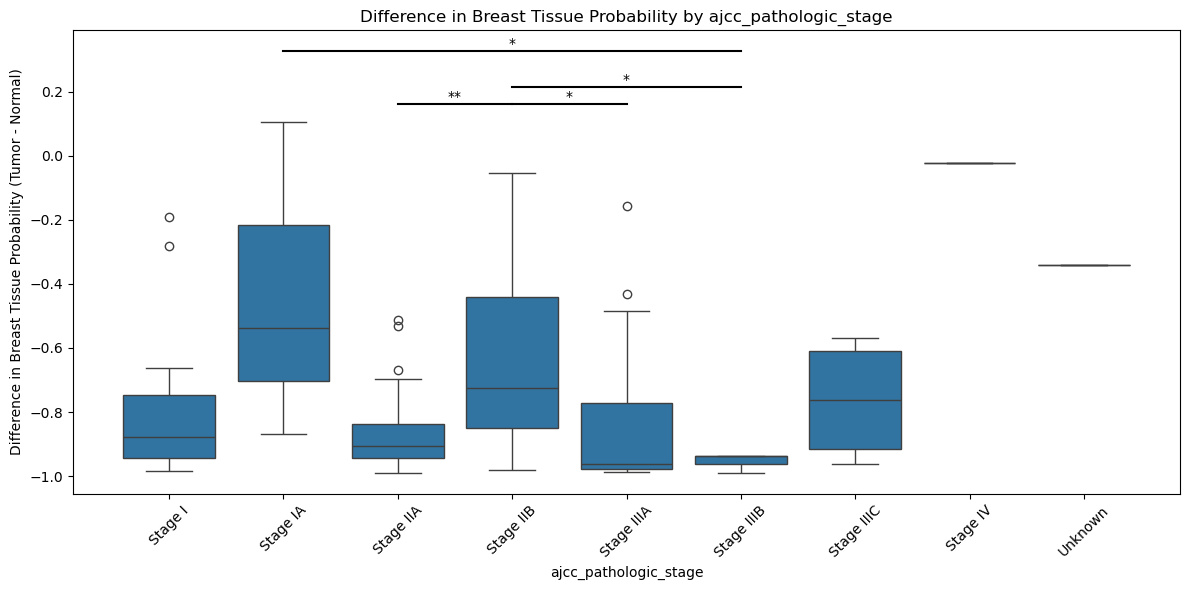

Stage IIA vs Stage IA: statistic = -2.1776, p-value = 0.0294
Stage IIA vs Stage IIB: statistic = -3.1138, p-value = 0.0018
Stage IIA vs Stage IIIA: statistic = 1.2561, p-value = 0.2091
Stage IIA vs Stage I: statistic = -0.6920, p-value = 0.4889
Stage IIA vs Stage IIIC: statistic = -0.8839, p-value = 0.3768
Stage IIA vs Stage IIIB: statistic = 1.6246, p-value = 0.1043
Stage IIA vs Unknown: statistic = -1.6713, p-value = 0.0947
Stage IIA vs Stage IV: statistic = -1.6713, p-value = 0.0947
Stage IA vs Stage IIB: statistic = 0.7715, p-value = 0.4404
Stage IA vs Stage IIIA: statistic = 1.6817, p-value = 0.0926
Stage IA vs Stage I: statistic = 1.6348, p-value = 0.1021
Stage IA vs Stage IIIC: statistic = 1.4142, p-value = 0.1573
Stage IA vs Stage IIIB: statistic = 1.9640, p-value = 0.0495
Stage IA vs Unknown: statistic = -0.4472, p-value = 0.6547
Stage IA vs Stage IV: statistic = -0.4472, p-value = 0.6547
Stage IIB vs Stage IIIA: statistic = 2.4497, p-value = 0.0143
Stage IIB vs Stage I: stati

In [38]:
plot_paired_diff(brca_meta_paired, brca_proba_paired, 'breast', 'ajcc_pathologic_stage')

In [39]:
# Assuming your DataFrame is called 'df' and the column with stages is called 'Stage'
brca_meta_paired['combined_stage'] = brca_meta_paired['ajcc_pathologic_stage'].str.replace(r'^Stage ([I-V]+).*', r'Stage \1', regex=True)

# If you want to verify the changes
print(brca_meta_paired['ajcc_pathologic_stage'].value_counts())
print(brca_meta_paired['combined_stage'].value_counts())

ajcc_pathologic_stage
Stage IIA     54
Stage IIB     48
Stage IIIA    26
Stage I       22
Stage IIIC     8
Stage IIIB     6
Stage IA       6
Stage IV       2
Name: count, dtype: int64
combined_stage
Stage II     102
Stage III     40
Stage I       28
Stage IV       2
Name: count, dtype: int64


In [40]:
brca_meta_paired['combined_stage'] = brca_meta_paired['combined_stage'].fillna("Unknown")
brca_meta_paired['combined_stage'].replace(to_replace='Stage IV', value='Stage III+', inplace=True)
brca_meta_paired['combined_stage'].replace(to_replace='Stage III', value='Stage III+', inplace=True)

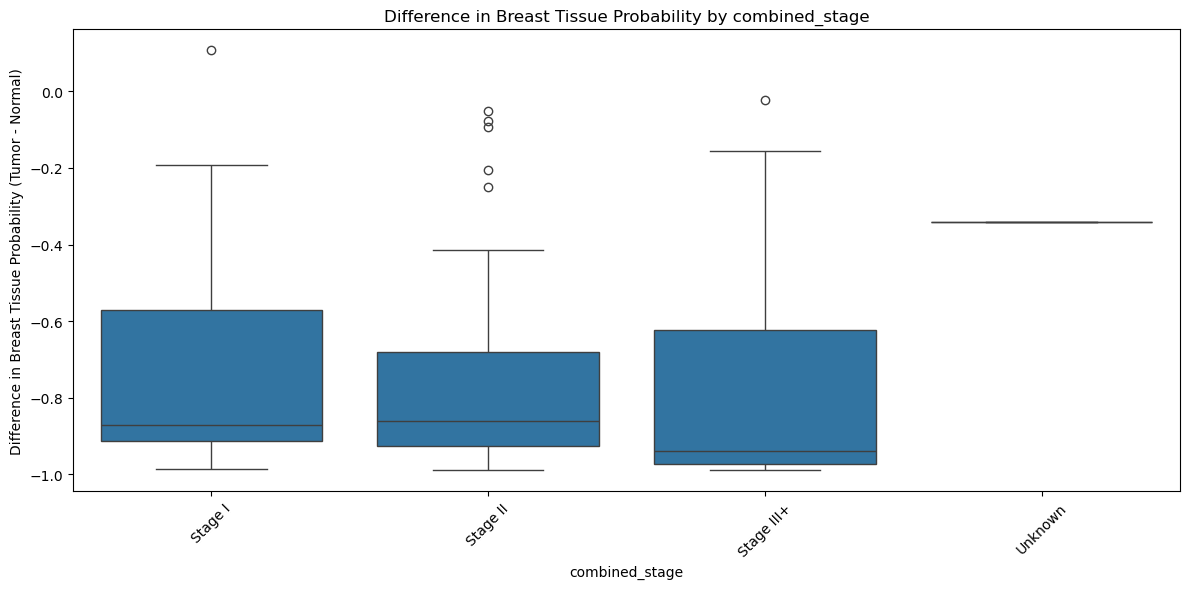

Stage II vs Stage I: statistic = -0.1915, p-value = 0.8481
Stage II vs Stage III+: statistic = 1.7406, p-value = 0.0817
Stage II vs Unknown: statistic = -1.3659, p-value = 0.1720
Stage I vs Stage III+: statistic = 1.3132, p-value = 0.1891
Stage I vs Unknown: statistic = -0.9258, p-value = 0.3545
Stage III+ vs Unknown: statistic = -1.3398, p-value = 0.1803


In [41]:
plot_paired_diff(brca_meta_paired, brca_proba_paired, 'breast', 'combined_stage')

In [42]:
brca_pred_proba.loc[brca_meta_paired[brca_meta_paired['combined_stage'] == 'Stage IV'].index]

,blood,breast,embryonic stem cell,exocrine gland,fibroblast,islet of Langerhans,leukocyte,liver,lymphocyte,monocyte,...,pancreas,peripheral blood mononuclear cell,placenta,prostate epithelium,reproductive structure,saliva,simple columnar epithelium,sperm,umbilical cord blood,visceral fat
barcode,,,,,,,,,,,,,,,,,,,,,


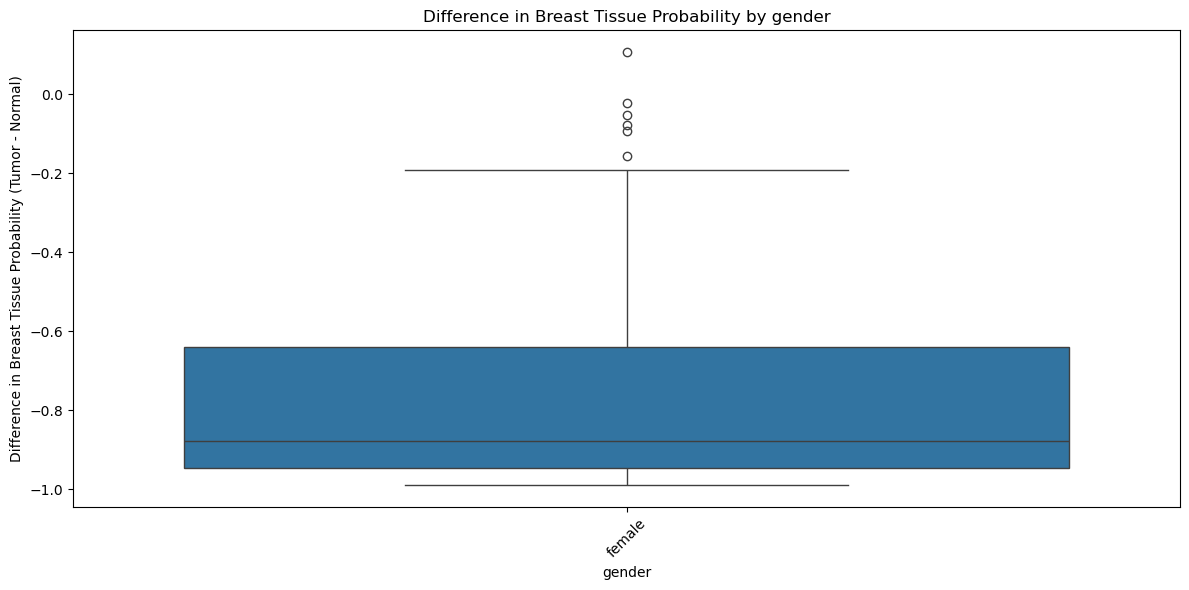

In [43]:
plot_paired_diff(brca_meta_paired, brca_proba_paired, 'breast', 'gender')

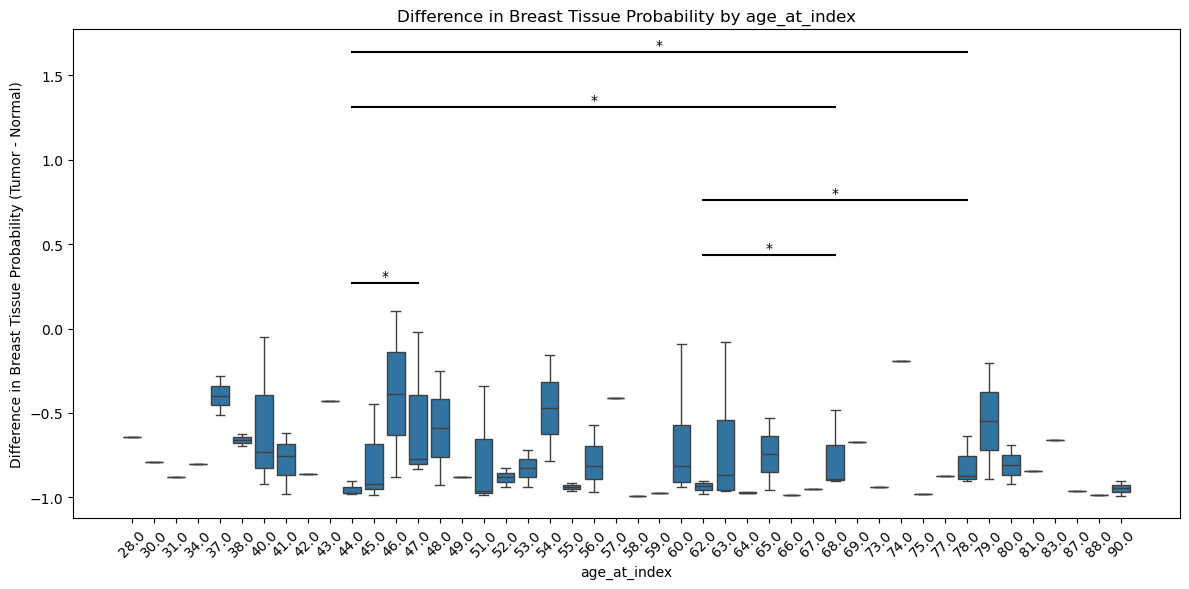

37.0 vs 63.0: statistic = 1.1619, p-value = 0.2453
37.0 vs 62.0: statistic = 1.8516, p-value = 0.0641
37.0 vs 44.0: statistic = 1.7321, p-value = 0.0833
37.0 vs 90.0: statistic = 1.5492, p-value = 0.1213
37.0 vs 65.0: statistic = 1.5492, p-value = 0.1213
37.0 vs 40.0: statistic = 0.5774, p-value = 0.5637
37.0 vs 79.0: statistic = 0.0000, p-value = 1.0000
37.0 vs 87.0: statistic = 1.2247, p-value = 0.2207
37.0 vs 45.0: statistic = 1.1547, p-value = 0.2482
37.0 vs 47.0: statistic = 0.5774, p-value = 0.5637
37.0 vs 53.0: statistic = 1.5492, p-value = 0.1213
37.0 vs 64.0: statistic = 1.5492, p-value = 0.1213
37.0 vs 51.0: statistic = 1.1547, p-value = 0.2482
37.0 vs 60.0: statistic = 0.9258, p-value = 0.3545
37.0 vs 56.0: statistic = 1.7321, p-value = 0.0833
37.0 vs 41.0: statistic = 1.7321, p-value = 0.0833
37.0 vs 54.0: statistic = 0.0000, p-value = 1.0000
37.0 vs 55.0: statistic = 1.5492, p-value = 0.1213
37.0 vs 59.0: statistic = 1.2247, p-value = 0.2207
37.0 vs 30.0: statistic = 1.224

In [44]:
plot_paired_diff(brca_meta_paired, brca_proba_paired, 'breast', 'age_at_index')

In [45]:
[x for x in brca_meta_paired.columns if 'grade' in x.lower()]

['tumor_grade', 'paper_Tumor_Grade']

In [46]:
save_pred_proba = False

if save_pred_proba:
    with open(f"./../figures/BRCA_prediction", "wb") as f:
        dill.dump([brca_proba_paired, brca_meta_paired], f)

In [47]:
from scipy.stats import wilcoxon
normal_proba = brca_pred_proba.loc[brca_meta_paired[brca_meta_paired['sample_type'] == 'Solid Tissue Normal'].index]['breast']
tumor_proba = brca_pred_proba.loc[brca_meta_paired[brca_meta_paired['sample_type'] == 'Primary Tumor'].index]['breast']
statistic, p_value = wilcoxon(normal_proba, tumor_proba, alternative='greater')

print(f"Paired Wilcoxon signed-rank test: statistic = {statistic:.4f}, p-value = {p_value:.4f}")

Paired Wilcoxon signed-rank test: statistic = 3823.0000, p-value = 0.0000


In [48]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

def jonckheere_trend_test(data):
    """
    Perform Jonckheere's trend test
    """
    k = len(data)
    n = sum(len(group) for group in data)
    
    # Calculate the test statistic
    J = 0
    for i in range(k):
        for j in range(i+1, k):
            J += sum(x < y for x in data[i] for y in data[j])
    
    # Calculate mean and variance
    mean_J = n*(n-1)/4
    var_J = n*(2*n+3)*(n-1)/72
    
    # Calculate z-score
    z = (J - mean_J) / np.sqrt(var_J)
    
    # Calculate p-value
    p_value = 1 - stats.norm.cdf(z)
    
    return J, z, p_value


In [49]:
paired_diff = {}
for patient, group in brca_meta_paired.groupby('patient'):
    normal = group[group['sample_type'] == 'Solid Tissue Normal'].index[0]
    tumor = group[group['sample_type'] == 'Primary Tumor'].index[0]
    diff = brca_proba_paired.loc[tumor]['breast'] - brca_proba_paired.loc[normal]['breast']
    paired_diff[patient] = diff

paired_diff_df = pd.DataFrame.from_dict(paired_diff, orient='index', columns=[f'{cancer_type}_diff'])
paired_diff_df.rename_axis('patient', inplace=True)

In [50]:
brca_meta_tumor = brca_meta_paired[brca_meta_paired['sample_type'] == 'Primary Tumor']
brca_merged = pd.merge(paired_diff_df, brca_meta_tumor[['sample_type','combined_stage','patient']], on='patient')
# Create a mapping dictionary
stage_mapping = {
    'Stage I': 1,
    'Stage II': 2,
    'Stage III': 3,
    'Stage IV': 3  # Stage IV is also mapped to 3 as per your request
}

# Apply the mapping to the combined_stage column
brca_merged['numerical_stage'] = brca_merged['combined_stage'].map(stage_mapping)

# brca_merged.to_csv('brca_diff.csv')

In [51]:
# Assuming you have stage data in a list of lists format
stage1_data = brca_merged[brca_merged['combined_stage']=='Stage I']['BRCA_diff'].values
stage2_data = brca_merged[brca_merged['combined_stage']=='Stage II']['BRCA_diff'].values
stage3_data = brca_merged[brca_merged['combined_stage'].isin(['Stage III','Stage IV'])]['BRCA_diff'].values
stages_data = [stage1_data, stage2_data, stage3_data]

# Perform Jonckheere's trend test
J, z, p_value = jonckheere_trend_test(stages_data)

print(f"Jonckheere's statistic: {J}")
print(f"Z-score: {z}")
print(f"p-value: {p_value}")

# double checked funtion and output J with established R library(clinfun)

Jonckheere's statistic: 345
Z-score: -7.928272468688718
p-value: 0.9999999999999989


## merged csv for double checking function in R

In [52]:
brca_merged['combined_stage'].value_counts()

combined_stage
Stage II      51
Stage III+    21
Stage I       14
Unknown        1
Name: count, dtype: int64

In [53]:
pd.merge(brca_proba_paired['breast'], brca_meta_paired[['combined_stage', 'sample_type']], on = 'barcode')

,breast,combined_stage,sample_type
barcode,,,
TCGA-E2-A1L7-01A-11D-A145-05,0.054930,Stage III+,Primary Tumor
TCGA-E2-A1LI-01A-12D-A161-05,0.475429,Stage II,Primary Tumor
TCGA-BH-A1FD-01A-11D-A13K-05,0.086495,Stage I,Primary Tumor
TCGA-BH-A0DI-01A-21D-A12R-05,0.875664,Stage II,Primary Tumor
TCGA-AC-A2FG-01A-11D-A17F-05,0.794290,Stage II,Primary Tumor
...,...,...,...
TCGA-A7-A0DC-11A-41D-A10Q-05,0.870582,Stage I,Solid Tissue Normal
TCGA-A7-A0DC-01B-04D-A22R-05,0.001519,Stage I,Primary Tumor
TCGA-BH-A0C0-01A-21D-A10P-05,0.000763,Stage II,Primary Tumor


## percent normal cells (from Ruth)

In [54]:
percent_cells = pd.read_csv('./../workspace/percent_cells.txt', sep='\t', index_col=0)
percent_cells.head()

,bcr_slide_barcode,cellularity,endothelial_proliferation,nuclear_pleomorphism,number_proliferating_cells,palisading_necrosis,percent_eosinophil_infiltration,percent_granulocyte_infiltration,percent_inflam_infiltration,percent_lymphocyte_infiltration,percent_monocyte_infiltration,percent_necrosis,percent_neutrophil_infiltration,percent_normal_cells,percent_stromal_cells,percent_tumor_cells,percent_tumor_nuclei,section_location,bcr_slide_uuid
bcr_sample_barcode,,,,,,,,,,,,,,,,,,,
TCGA-A1-A0SB-01A,TCGA-A1-A0SB-01A-01-BS1,NaN,NaN,NaN,[Not Available],NaN,[Not Available],[Not Available],[Not Available],1,[Not Available],0,0,4,16,80,80,BOTTOM,0af5f17f-e9a6-4424-8eae-728878063437
TCGA-A1-A0SB-01A,TCGA-A1-A0SB-01A-01-TS1,NaN,NaN,NaN,[Not Available],NaN,[Not Available],[Not Available],[Not Available],1,[Not Available],0,0,1,14,85,85,TOP,ed80b57e-ce46-45d6-b8cf-bb18e254488f
TCGA-A1-A0SD-01A,TCGA-A1-A0SD-01A-01-BS1,NaN,NaN,NaN,[Not Available],NaN,[Not Available],[Not Available],[Not Available],2,[Not Available],0,0,15,60,25,25,BOTTOM,24ae9ce9-ef51-4cef-a095-1681d4bdd2fb
TCGA-A1-A0SD-01A,TCGA-A1-A0SD-01A-01-TS1,NaN,NaN,NaN,[Not Available],NaN,[Not Available],[Not Available],[Not Available],2,[Not Available],1,0,3,36,60,60,TOP,6a18f1d4-bee3-453c-a84f-0f82f93e95f2
TCGA-A1-A0SE-01A,TCGA-A1-A0SE-01A-01-BS1,NaN,NaN,NaN,[Not Available],NaN,[Not Available],[Not Available],[Not Available],2,[Not Available],0,0,7,13,80,80,BOTTOM,bc41fb6d-f6a5-495c-b429-80d289f0bda1


In [55]:
brca_merged = pd.merge(brca_merged, brca_meta_tumor.reset_index()[['patient','sample_submitter_id']], on='patient', how='left')
brca_merged

,patient,BRCA_diff,sample_type,combined_stage,numerical_stage,sample_submitter_id
0,TCGA-A7-A0D9,-0.511249,Primary Tumor,Stage II,2.0,TCGA-A7-A0D9-01A
1,TCGA-A7-A0DC,-0.869063,Primary Tumor,Stage I,1.0,TCGA-A7-A0DC-01B
2,TCGA-A7-A13E,-0.903481,Primary Tumor,Stage II,2.0,TCGA-A7-A13E-01A
3,TCGA-A7-A13F,-0.973963,Primary Tumor,Stage III+,NaN,TCGA-A7-A13F-01A
4,TCGA-AC-A23H,-0.904889,Primary Tumor,Stage II,2.0,TCGA-AC-A23H-01A
...,...,...,...,...,...,...
82,TCGA-E9-A1RC,-0.569857,Primary Tumor,Stage III+,NaN,TCGA-E9-A1RC-01A
83,TCGA-E9-A1RD,-0.947525,Primary Tumor,Stage II,2.0,TCGA-E9-A1RD-01A
84,TCGA-E9-A1RF,-0.483612,Primary Tumor,Stage III+,NaN,TCGA-E9-A1RF-01A
85,TCGA-E9-A1RH,-0.953714,Primary Tumor,Stage II,2.0,TCGA-E9-A1RH-01A


In [56]:
brca_merged = pd.merge(brca_merged, percent_cells[['percent_normal_cells','percent_tumor_cells','percent_tumor_nuclei','percent_lymphocyte_infiltration']], left_on='sample_submitter_id', right_on='bcr_sample_barcode')

In [57]:
def plot_diff_by_category(plot_data, stage_column):
    from itertools import combinations
    from scipy.stats import ranksums

    plot_data[stage_column] = plot_data[stage_column].fillna('Unknown')

    stages = ["Stage I", "Stage IA", "Stage IB", "Stage II", "Stage IIA", "Stage IIB", 
              "Stage III", "Stage IIIA", "Stage IIIB", "Stage IIIC", "Stage IV", "Unknown"]
    
    if stage_column=="ajcc_pathologic_stage":
        labels=stages
    else:
        labels=sorted(plot_data[stage_column].unique())

    def custom_sort(item):
        if item == "Unknown":
            return len(labels)
        return labels.index(item)

    ordered_grades = sorted(plot_data[stage_column].unique(), key=custom_sort)

    plot_data[stage_column] = pd.Categorical(
        plot_data[stage_column],
        categories=ordered_grades,
        ordered=True
    )
    
    # Perform pairwise Wilcoxon rank-sum tests
    stages = plot_data[stage_column].unique()
    results = {}
    
    for stage1, stage2 in combinations(stages, 2):
        stage1_data = plot_data[plot_data[stage_column] == stage1][f'{cancer_type}_diff']
        stage2_data = plot_data[plot_data[stage_column] == stage2][f'{cancer_type}_diff']
        statistic, p_value = ranksums(stage1_data, stage2_data)
        results[(stage1, stage2)] = {'statistic': statistic, 'p_value': p_value}

    plt.figure(figsize=(12, 6))
    sns.boxplot(x=stage_column, y=f'{cancer_type}_diff', data=plot_data, order=ordered_grades)
    plt.title(f'Difference in {cancer_type.capitalize()} Tissue Probability by {stage_column}')
    plt.xlabel(stage_column)
    plt.ylabel(f'Difference in {cancer_type.capitalize()} Tissue Probability (Tumor - Normal)')
    plt.xticks(rotation=45)

    # Add significance markers to the plot
    y_max = plot_data[f'{cancer_type}_diff'].max()
    y_range = plot_data[f'{cancer_type}_diff'].max() - plot_data[f'{cancer_type}_diff'].min()
    
    for i, stage1 in enumerate(ordered_grades):
        for j, stage2 in enumerate(ordered_grades[i+1:], start=i+1):
            if (stage1, stage2) in results:
                p_value = results[(stage1, stage2)]['p_value']
                if p_value < 0.001:
                    marker = '***'
                elif p_value < 0.01:
                    marker = '**'
                elif p_value < 0.05:
                    marker = '*'
                else:
                    continue  # Don't show non-significant comparisons
                
                y = y_max + 0.05 * y_range * (j - i)
                plt.plot([i, j], [y, y], 'k-')
                plt.text((i + j) / 2, y, marker, ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Print detailed results
    for (stage1, stage2), result in results.items():
        print(f"{stage1} vs {stage2}: statistic = {result['statistic']:.4f}, p-value = {result['p_value']:.4f}")
    
    plt.show()

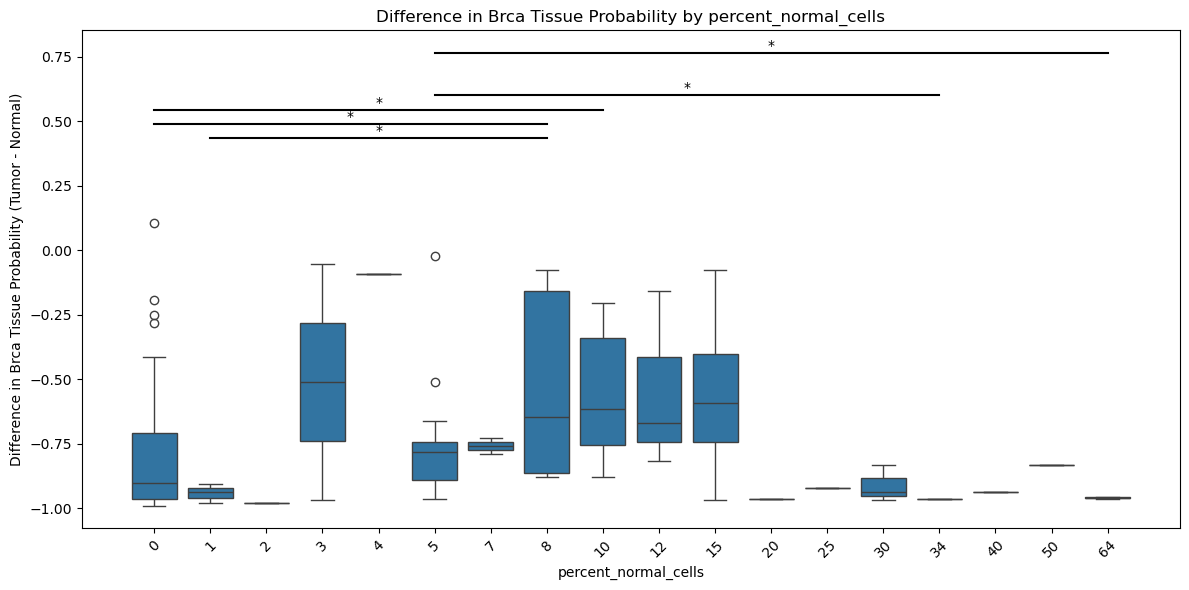

5 vs 15: statistic = -1.0950, p-value = 0.2735
5 vs 0: statistic = 1.7403, p-value = 0.0818
5 vs 3: statistic = 0.1198, p-value = 0.9046
5 vs 10: statistic = -1.8126, p-value = 0.0699
5 vs 34: statistic = 2.2764, p-value = 0.0228
5 vs 25: statistic = 1.5575, p-value = 0.1193
5 vs 30: statistic = 1.7700, p-value = 0.0767
5 vs 64: statistic = 2.0367, p-value = 0.0417
5 vs 12: statistic = -1.2437, p-value = 0.2136
5 vs 20: statistic = 1.6475, p-value = 0.0995
5 vs 1: statistic = 2.2483, p-value = 0.0246
5 vs 50: statistic = 0.4336, p-value = 0.6646
5 vs 7: statistic = -0.4792, p-value = 0.6318
5 vs 8: statistic = -1.2795, p-value = 0.2007
5 vs 40: statistic = 1.2140, p-value = 0.2248
5 vs 4: statistic = -1.4741, p-value = 0.1405
5 vs 2: statistic = 1.6475, p-value = 0.0995
15 vs 0: statistic = 1.4375, p-value = 0.1506
15 vs 3: statistic = 0.0000, p-value = 1.0000
15 vs 10: statistic = 0.0000, p-value = 1.0000
15 vs 34: statistic = 0.9258, p-value = 0.3545
15 vs 25: statistic = 0.9258, p-v

In [58]:
plot_diff_by_category(brca_merged, 'percent_normal_cells')

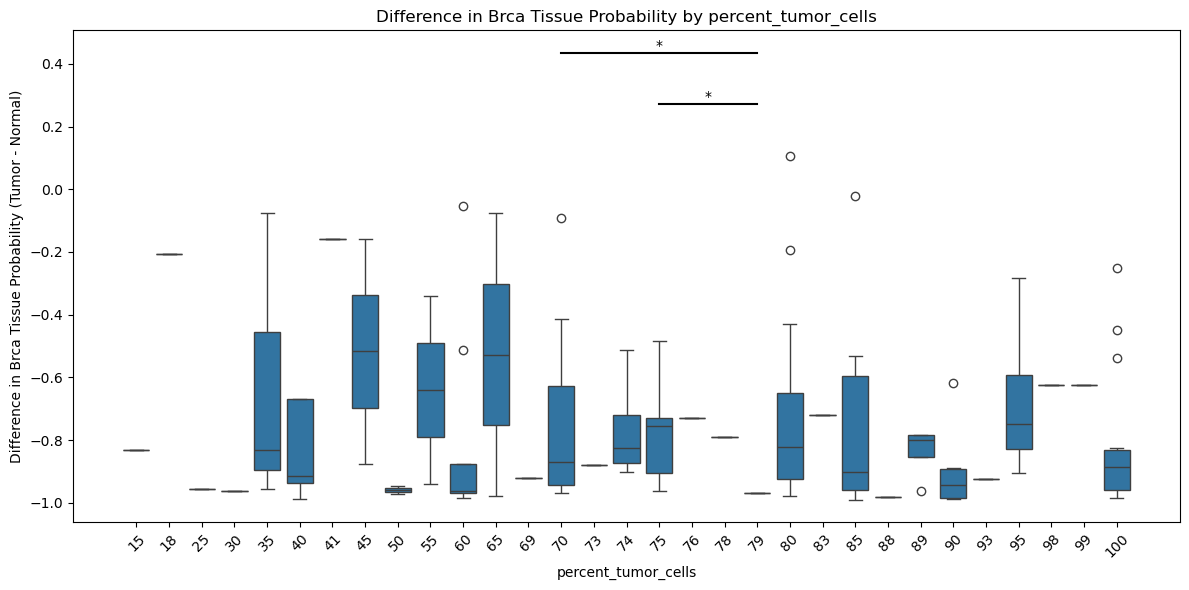

60 vs 74: statistic = -1.4659, p-value = 0.1427
60 vs 95: statistic = -1.5430, p-value = 0.1228
60 vs 100: statistic = -0.5669, p-value = 0.5708
60 vs 75: statistic = -1.6777, p-value = 0.0934
60 vs 85: statistic = -0.4763, p-value = 0.6338
60 vs 18: statistic = -1.2185, p-value = 0.2230
60 vs 69: statistic = -0.7071, p-value = 0.4795
60 vs 70: statistic = -1.5635, p-value = 0.1179
60 vs 80: statistic = -1.7638, p-value = 0.0778
60 vs 83: statistic = -0.8704, p-value = 0.3841
60 vs 30: statistic = -0.1741, p-value = 0.8618
60 vs 89: statistic = -1.2344, p-value = 0.2170
60 vs 79: statistic = 1.1785, p-value = 0.2386
60 vs 50: statistic = 0.3536, p-value = 0.7237
60 vs 88: statistic = 1.2185, p-value = 0.2230
60 vs 15: statistic = -0.8704, p-value = 0.3841
60 vs 35: statistic = -1.3868, p-value = 0.1655
60 vs 78: statistic = -0.8704, p-value = 0.3841
60 vs 65: statistic = 0.0000, p-value = 1.0000
60 vs 73: statistic = -0.5222, p-value = 0.6015
60 vs 76: statistic = -0.8704, p-value = 0.

In [59]:
plot_diff_by_category(brca_merged, 'percent_tumor_cells')

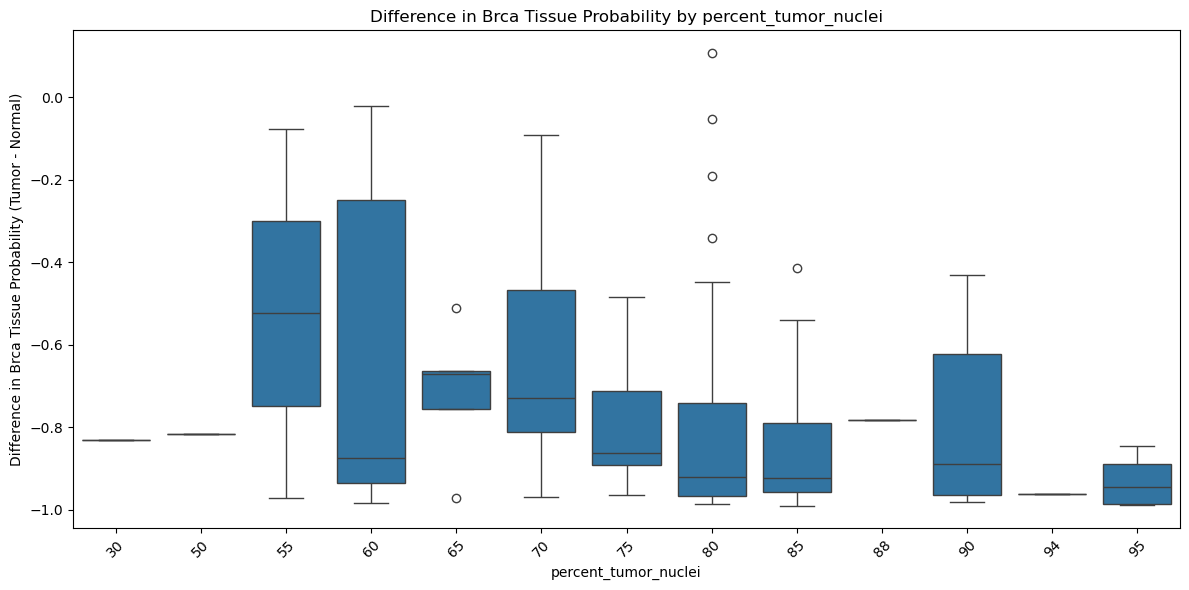

65 vs 90: statistic = 0.7886, p-value = 0.4304
65 vs 95: statistic = 1.9596, p-value = 0.0500
65 vs 75: statistic = 0.8497, p-value = 0.3955
65 vs 60: statistic = 0.5422, p-value = 0.5877
65 vs 80: statistic = 1.1677, p-value = 0.2429
65 vs 85: statistic = 1.2036, p-value = 0.2287
65 vs 70: statistic = 0.0826, p-value = 0.9342
65 vs 94: statistic = 0.8783, p-value = 0.3798
65 vs 50: statistic = 0.8783, p-value = 0.3798
65 vs 88: statistic = 0.8783, p-value = 0.3798
65 vs 55: statistic = -0.1936, p-value = 0.8465
65 vs 30: statistic = 0.8783, p-value = 0.3798
90 vs 95: statistic = 1.6418, p-value = 0.1006
90 vs 75: statistic = -0.4056, p-value = 0.6851
90 vs 60: statistic = -0.4872, p-value = 0.6261
90 vs 80: statistic = 0.4331, p-value = 0.6649
90 vs 85: statistic = 0.6733, p-value = 0.5007
90 vs 70: statistic = -1.8857, p-value = 0.0593
90 vs 94: statistic = 0.6202, p-value = 0.5351
90 vs 50: statistic = -0.3721, p-value = 0.7098
90 vs 88: statistic = -0.3721, p-value = 0.7098
90 vs 5

In [60]:
plot_diff_by_category(brca_merged, 'percent_tumor_nuclei')

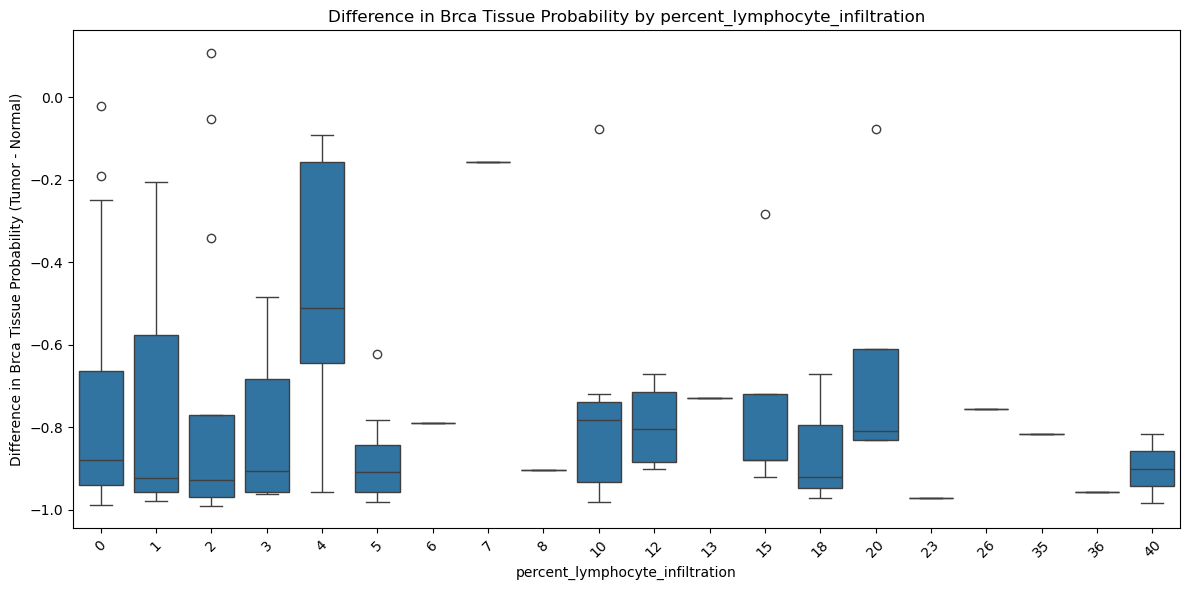

1 vs 4: statistic = -1.5309, p-value = 0.1258
1 vs 0: statistic = -0.1661, p-value = 0.8681
1 vs 2: statistic = 0.3411, p-value = 0.7330
1 vs 18: statistic = 0.3381, p-value = 0.7353
1 vs 15: statistic = -0.9798, p-value = 0.3272
1 vs 10: statistic = -0.3904, p-value = 0.6963
1 vs 12: statistic = -0.8485, p-value = 0.3961
1 vs 40: statistic = 0.8593, p-value = 0.3902
1 vs 35: statistic = -0.3162, p-value = 0.7518
1 vs 26: statistic = -0.6325, p-value = 0.5271
1 vs 5: statistic = 0.5775, p-value = 0.5636
1 vs 23: statistic = 1.2649, p-value = 0.2059
1 vs 20: statistic = -1.1314, p-value = 0.2579
1 vs 6: statistic = -0.3162, p-value = 0.7518
1 vs 3: statistic = 0.0000, p-value = 1.0000
1 vs 13: statistic = -0.6325, p-value = 0.5271
1 vs 7: statistic = -1.5811, p-value = 0.1138
1 vs 36: statistic = 0.6325, p-value = 0.5271
1 vs 8: statistic = -0.3162, p-value = 0.7518
4 vs 0: statistic = 1.8881, p-value = 0.0590
4 vs 2: statistic = 1.5279, p-value = 0.1265
4 vs 18: statistic = 1.6398, p-v

In [61]:
plot_diff_by_category(brca_merged, 'percent_lymphocyte_infiltration')

## binned percent cell

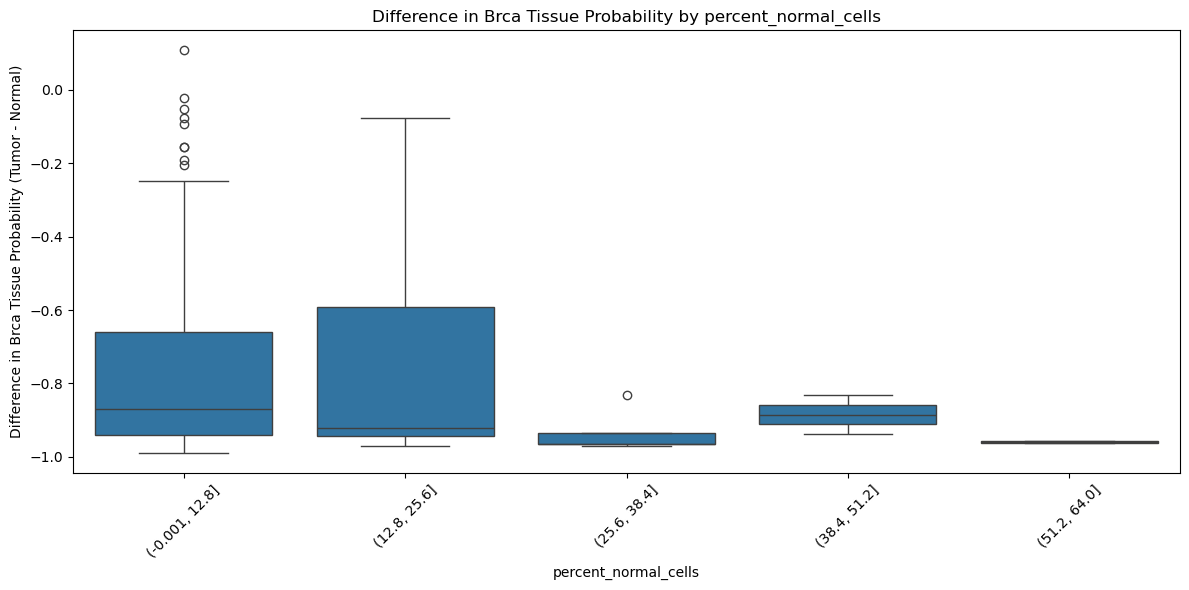

In [62]:
def plot_diff_by_category_binned(plot_data, stage_column, cancer_type, display=False, bin_edges=None):
    from itertools import combinations
    from scipy.stats import ranksums
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    # Check if the stage column is numeric
    plot_data[stage_column] = pd.to_numeric(plot_data[stage_column], errors='coerce')
    
    if bin_edges is None:
        # Create default bins if not provided
        bin_edges = np.linspace(plot_data[stage_column].min(), plot_data[stage_column].max(), 6)
    
    plot_data = plot_data.sort_values(by=[stage_column])
    plot_data[stage_column] = plot_data[stage_column].fillna('Unknown')
    
    # Create a new column with binned stages
    plot_data['stage_binned'] = pd.cut(plot_data[stage_column], bins=bin_edges, include_lowest=True)
    original_column = stage_column
    stage_column = 'stage_binned'  # Use the binned column for further processing

    ordered_grades = plot_data[stage_column].cat.categories

    # Perform pairwise Wilcoxon rank-sum tests
    results = {}
    for stage1, stage2 in combinations(ordered_grades, 2):
        stage1_data = plot_data[plot_data[stage_column] == stage1][f'{cancer_type}_diff']
        stage2_data = plot_data[plot_data[stage_column] == stage2][f'{cancer_type}_diff']
        statistic, p_value = ranksums(stage1_data, stage2_data)
        results[(stage1, stage2)] = {'statistic': statistic, 'p_value': p_value}

    plt.figure(figsize=(12, 6))
    sns.boxplot(x=stage_column, y=f'{cancer_type}_diff', data=plot_data, order=ordered_grades)
    plt.title(f'Difference in {cancer_type.capitalize()} Tissue Probability by {original_column}')
    plt.xlabel(original_column)
    plt.ylabel(f'Difference in {cancer_type.capitalize()} Tissue Probability (Tumor - Normal)')
    plt.xticks(rotation=45)

    # Add significance markers to the plot
    y_max = plot_data[f'{cancer_type}_diff'].max()
    y_range = plot_data[f'{cancer_type}_diff'].max() - plot_data[f'{cancer_type}_diff'].min()
    for i, stage1 in enumerate(ordered_grades):
        for j, stage2 in enumerate(ordered_grades[i+1:], start=i+1):
            if (stage1, stage2) in results:
                p_value = results[(stage1, stage2)]['p_value']
                if p_value < 0.001:
                    marker = '***'
                elif p_value < 0.01:
                    marker = '**'
                elif p_value < 0.05:
                    marker = '*'
                else:
                    continue  # Don't show non-significant comparisons
                y = y_max + 0.05 * y_range * (j - i)
                plt.plot([i, j], [y, y], 'k-')
                plt.text((i + j) / 2, y, marker, ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
    
    if display:
        # Print detailed results
        for (stage1, stage2), result in results.items():
            print(f"{stage1} vs {stage2}: statistic = {result['statistic']:.4f}, p-value = {result['p_value']:.4f}")

# Example usage
plot_diff_by_category_binned(brca_merged, 'percent_normal_cells', 'BRCA')

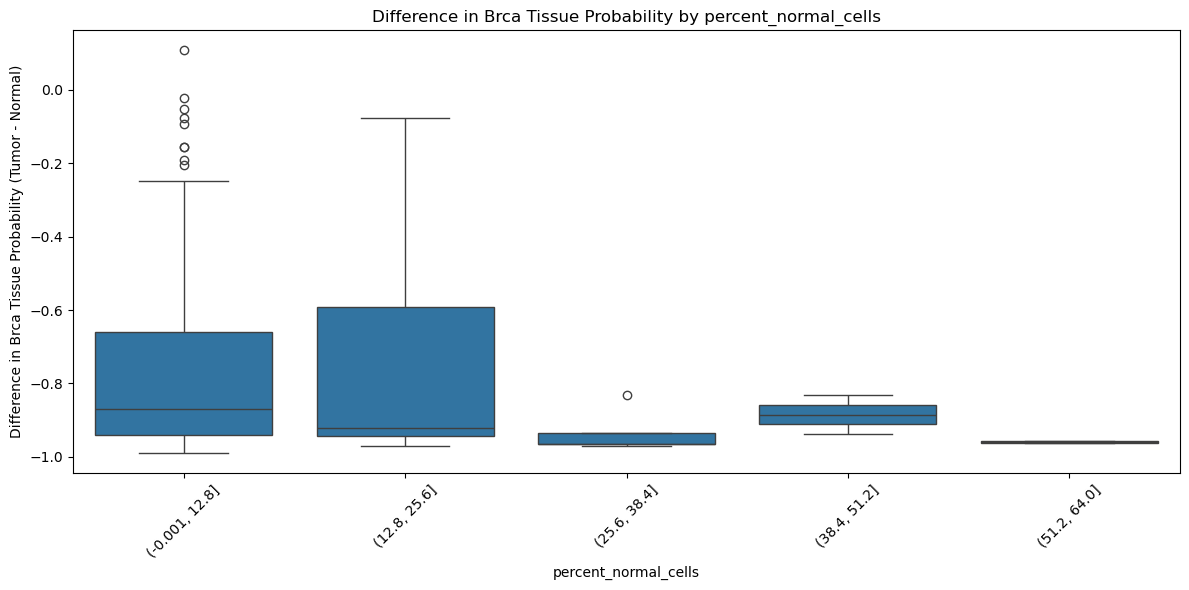

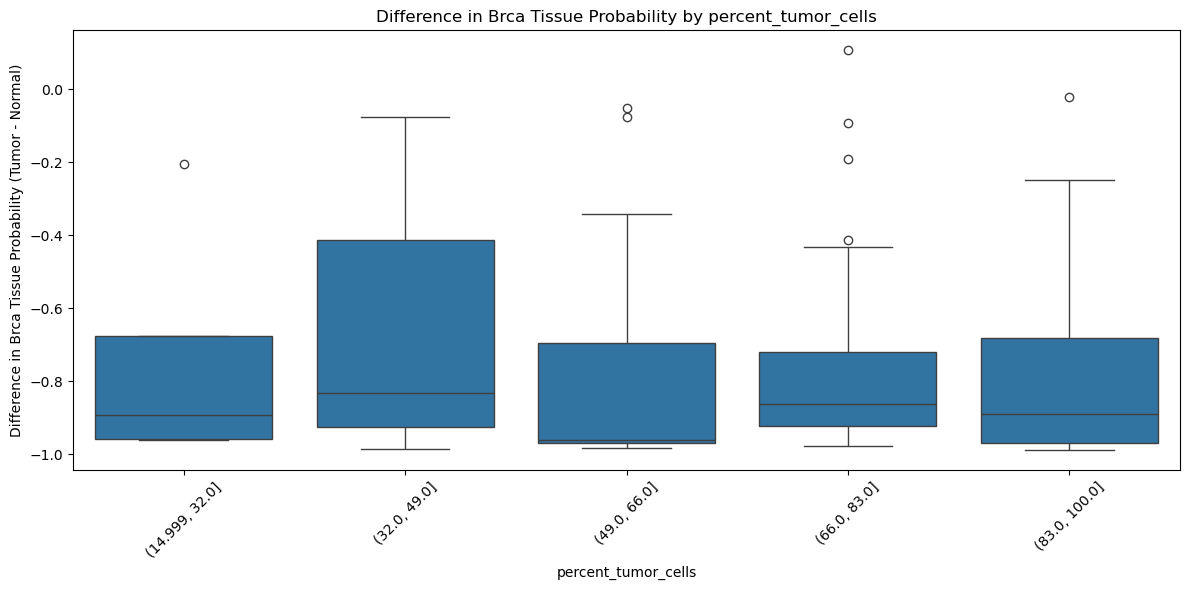

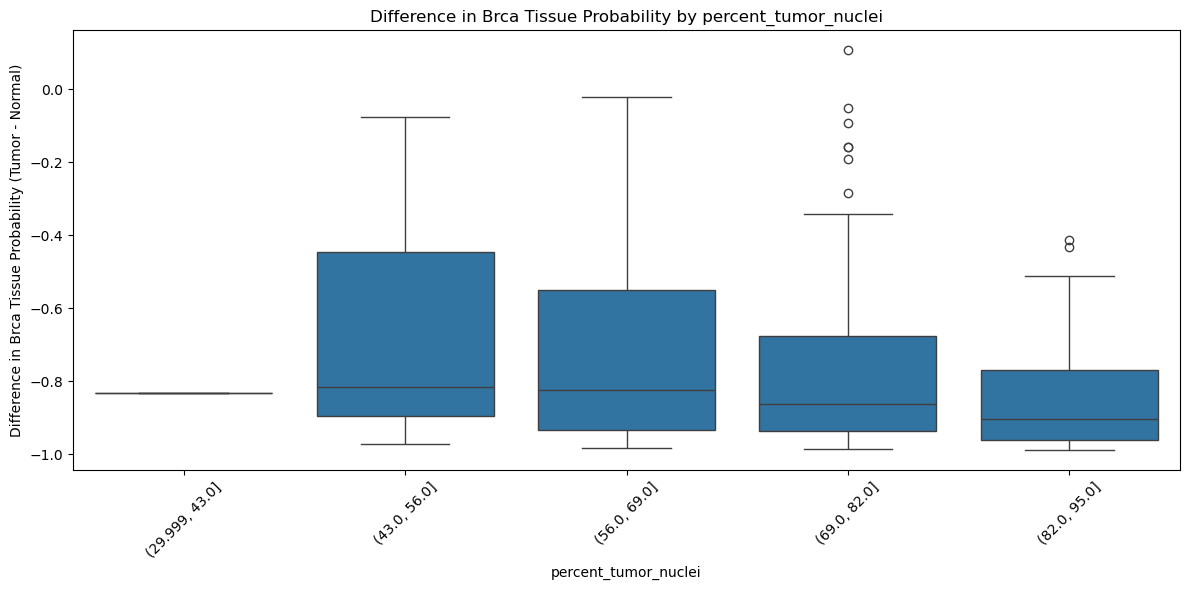

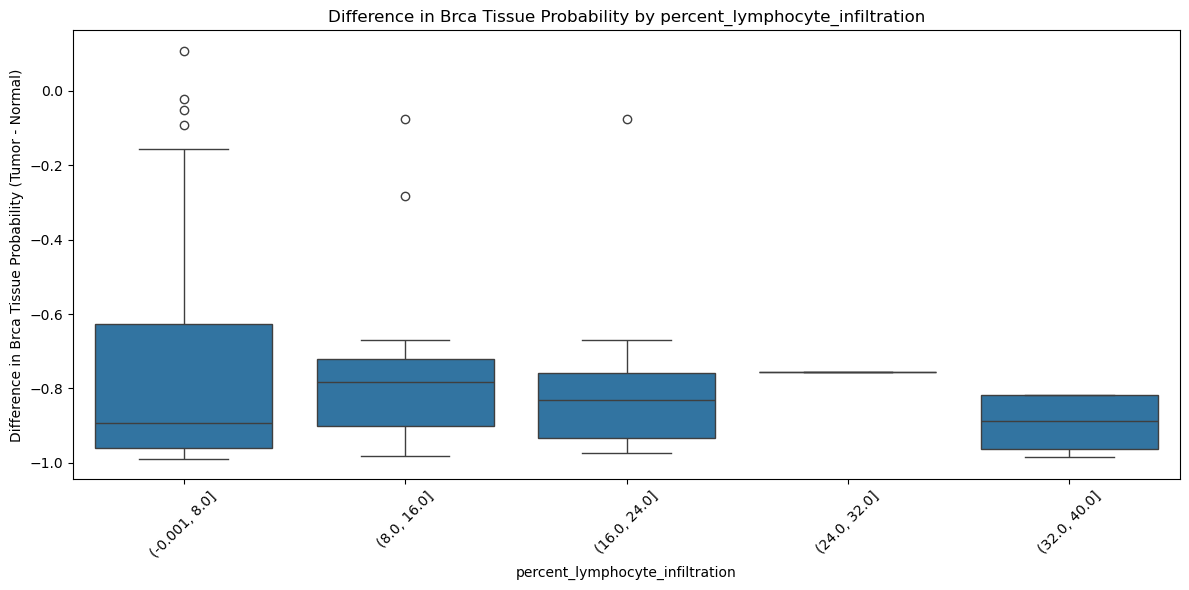

In [63]:
plot_diff_by_category_binned(brca_merged, 'percent_normal_cells', 'BRCA')
plot_diff_by_category_binned(brca_merged, 'percent_tumor_cells', 'BRCA')
plot_diff_by_category_binned(brca_merged, 'percent_tumor_nuclei', 'BRCA')
plot_diff_by_category_binned(brca_merged, 'percent_lymphocyte_infiltration', 'BRCA')

## survival

In [64]:
brca_meta_tumor['days_to_death'].value_counts()

days_to_death
1009.0    1
792.0     1
2798.0    1
2192.0    1
786.0     1
1034.0    1
785.0     1
2534.0    1
959.0     1
678.0     1
2965.0    1
2712.0    1
1324.0    1
365.0     1
3472.0    1
1927.0    1
2520.0    1
2127.0    1
1642.0    1
1174.0    1
1388.0    1
1759.0    1
577.0     1
3959.0    1
1.0       1
1072.0    1
976.0     1
0.0       1
1286.0    1
538.0     1
1694.0    1
3669.0    1
614.0     1
Name: count, dtype: int64

In [65]:
brca_meta_tumor.paper_vital_status.value_counts()

paper_vital_status
Alive    54
Dead     33
Name: count, dtype: int64

In [66]:
from lifelines import KaplanMeierFitter

In [67]:
brca_meta_tumor['days_to_last_follow_up']

barcode
TCGA-E2-A1L7-01A-11D-A145-05    1836.0
TCGA-E2-A1LI-01A-12D-A161-05    3121.0
TCGA-BH-A1FD-01A-11D-A13K-05       NaN
TCGA-BH-A0DI-01A-21D-A12R-05     912.0
TCGA-AC-A2FG-01A-11D-A17F-05    1853.0
                                 ...  
TCGA-BH-A0DV-01A-21D-A12R-05    2064.0
TCGA-BH-A0E1-01A-11D-A10P-05     477.0
TCGA-A7-A0DC-01B-04D-A22R-05     906.0
TCGA-BH-A0C0-01A-21D-A10P-05    1270.0
TCGA-E2-A1IO-01A-11D-A145-05    1855.0
Name: days_to_last_follow_up, Length: 87, dtype: float64

In [68]:
brca_meta_tumor['days_to_death']

barcode
TCGA-E2-A1L7-01A-11D-A145-05       NaN
TCGA-E2-A1LI-01A-12D-A161-05       NaN
TCGA-BH-A1FD-01A-11D-A13K-05    1009.0
TCGA-BH-A0DI-01A-21D-A12R-05       NaN
TCGA-AC-A2FG-01A-11D-A17F-05       NaN
                                 ...  
TCGA-BH-A0DV-01A-21D-A12R-05       NaN
TCGA-BH-A0E1-01A-11D-A10P-05       NaN
TCGA-A7-A0DC-01B-04D-A22R-05       NaN
TCGA-BH-A0C0-01A-21D-A10P-05       NaN
TCGA-E2-A1IO-01A-11D-A145-05       NaN
Name: days_to_death, Length: 87, dtype: float64

In [69]:
brca_meta_tumor['days_to_death'].fillna(brca_meta_tumor['days_to_last_follow_up'])

barcode
TCGA-E2-A1L7-01A-11D-A145-05    1836.0
TCGA-E2-A1LI-01A-12D-A161-05    3121.0
TCGA-BH-A1FD-01A-11D-A13K-05    1009.0
TCGA-BH-A0DI-01A-21D-A12R-05     912.0
TCGA-AC-A2FG-01A-11D-A17F-05    1853.0
                                 ...  
TCGA-BH-A0DV-01A-21D-A12R-05    2064.0
TCGA-BH-A0E1-01A-11D-A10P-05     477.0
TCGA-A7-A0DC-01B-04D-A22R-05     906.0
TCGA-BH-A0C0-01A-21D-A10P-05    1270.0
TCGA-E2-A1IO-01A-11D-A145-05    1855.0
Name: days_to_death, Length: 87, dtype: float64

Text(0.5, 0, 'Time (days)')

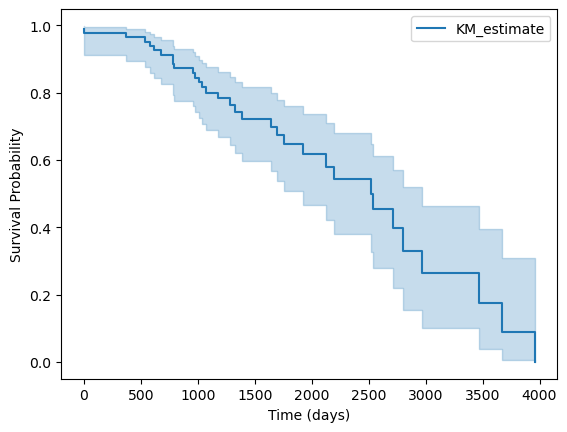

In [70]:
T = brca_meta_tumor['days_to_death'].fillna(brca_meta_tumor['days_to_last_follow_up']).values
E = brca_meta_tumor['paper_vital_status'].map({'Alive':0, 'Dead':1}).values

kmf = KaplanMeierFitter()
kmf.fit(durations = T, event_observed = E)
kmf.plot_survival_function()
plt.ylabel('Survival Probability')
plt.xlabel('Time (days)')

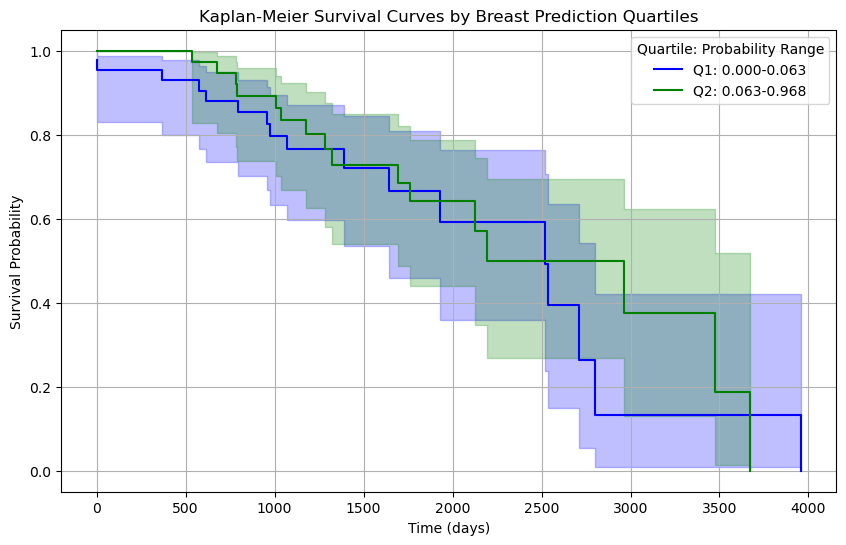

In [91]:
brca_proba_tumor = brca_pred_proba.loc[brca_meta_tumor.index]

# Assuming brca_meta_tumor and brca_proba_tumor are already defined
T = brca_meta_tumor['days_to_death'].fillna(brca_meta_tumor['days_to_last_follow_up']).values
E = brca_meta_tumor['paper_vital_status'].map({'Alive':0, 'Dead':1}).values

# Calculate quartiles based on breast prediction values
breast_pred = brca_proba_tumor['breast'].values
quartiles, bins = pd.qcut(breast_pred, 2, 
                         # labels=['Q1', 'Q2', 'Q3', 'Q4'], 
                         retbins=True)

# Create a plot
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for each quartile
colors = ['blue', 'green', 'red', 'purple']

# Fit and plot KM curve for each quartile
for i, (quartile, color) in enumerate(zip(quartiles.categories, colors)):
    mask = quartiles == quartile
    kmf = KaplanMeierFitter()
    kmf.fit(durations=T[mask], event_observed=E[mask], label=f'Q{i+1}: {bins[i]:.3f}-{bins[i+1]:.3f}')
    kmf.plot_survival_function(ax=ax, ci_show=True, color=color)

plt.ylabel('Survival Probability')
plt.xlabel('Time (days)')
plt.title('Kaplan-Meier Survival Curves by Breast Prediction Quartiles')
plt.legend(title='Quartile: Probability Range', loc='best')
plt.grid(True)
plt.show()

In [92]:
quartiles.value_counts()

(-0.000859, 0.0629]    44
(0.0629, 0.968]        43
Name: count, dtype: int64

In [93]:
brca_meta_tumor['paper_vital_status'].value_counts()

paper_vital_status
Alive    54
Dead     33
Name: count, dtype: int64

In [87]:
pd.DataFrame([T[mask], E[mask], brca_meta_tumor.loc[mask]['combined_stage'], brca_proba_tumor.loc[mask]['breast']], 
             index=['time','status','combined_stage','breast']).T

,time,status,combined_stage,breast
0,912.0,0,Stage II,0.875664
1,1853.0,0,Stage II,0.79429
2,3669.0,1,Stage II,0.902788
3,1138.0,0,Stage I,0.804928
4,1759.0,1,Stage II,0.728985
5,1604.0,0,Stage I,0.872337
6,1120.0,0,Stage II,0.540762
7,2759.0,0,Stage II,0.945119
8,1449.0,0,Stage III+,0.552737
9,2965.0,1,Unknown,0.65351


In [73]:
# avoid_col = [x[0] for x in brca_meta_tumor[~brca_meta_tumor['ajcc_pathologic_stage'].isna()].isnull().sum().items() if x[1]>0]

In [118]:
import copy

og_brca_meta_tumor = copy.deepcopy(brca_meta_tumor)
og_brca_proba_tumor = copy.deepcopy(brca_proba_tumor)

In [117]:
brca_meta_tumor_all = brca_meta[brca_meta['sample_type'] == 'Primary Tumor']
brca_proba_tumor_all = brca_pred_proba.loc[brca_meta_tumor_all.index]

In [122]:
data.isnull().any()

time                True
status              True
numerical_stage    False
pred_proba         False
age_binned          True
dtype: bool

age_binned
1    309
2    290
3     93
0     91
Name: count, dtype: int64


<lifelines.CoxPHFitter: fitted with 783 total observations, 681 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 783
number of events observed = 102
   partial log-likelihood = -544.63
         time fit was run = 2024-10-02 22:15:59 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
numerical_stage  -0.94       0.39       0.39            -1.70            -0.18                 0.18                 0.83
pred_proba       -0.05       0.95       0.32            -0.68             0.58                 0.51                 1.78
age_binned        0.54       1.72       0.12             0.30             0.78                 1.35                 2.19

                  cmp to     z      p   -log2(p)
covariate                                       
numerical_stage     0.00 -2.44   0.01       6.07
pred_proba          0.00 -0.16   0.87       0.20
age_binned          0.00  4.40 <0.005      16.48
---
Concordance = 0.66
Partial AIC = 1095.25
log-likelihood ratio test = 25.68 on 3 df
-log2(p) of ll-ratio test = 16.45

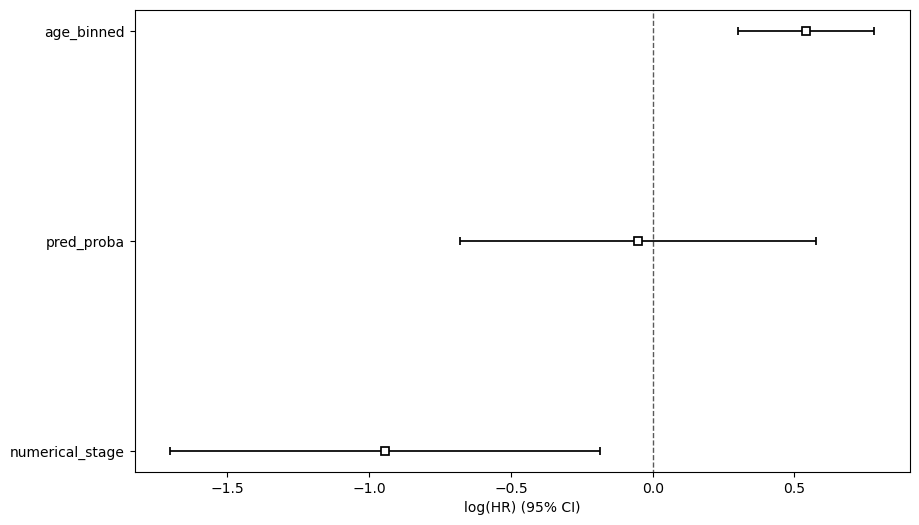

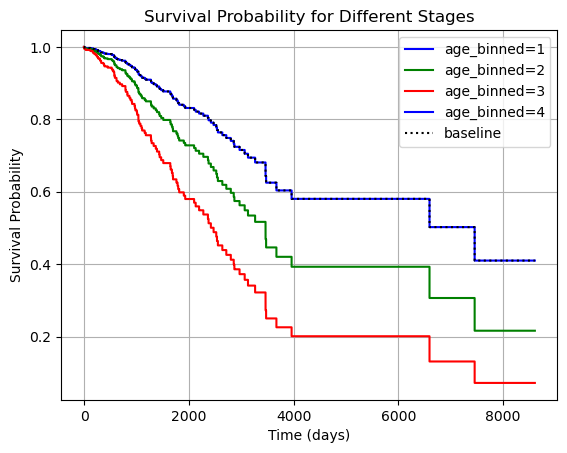

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 783 total observations, 681 right-censored observations>
         test_name = proportional_hazard_test

---
                      test_statistic    p  -log2(p)
age_binned      km              3.11 0.08      3.68
                rank            3.75 0.05      4.24
numerical_stage km              0.78 0.38      1.41
                rank            0.79 0.37      1.42
pred_proba      km              0.32 0.57      0.81
                rank            0.00 0.99      0.02



1. Variable 'age_binned' failed the non-proportional test: p-value is 0.0530.

   Advice: with so few unique values (only 4), you can include `strata=['age_binned', ...]` in the
call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification

[]


In [123]:
from lifelines import CoxPHFitter
# brca_meta_tumor = copy.deepcopy(og_brca_meta_tumor)

brca_meta_tumor = brca_meta_tumor_all
brca_proba_tumor = brca_proba_tumor_all

brca_meta_tumor['combined_stage'] = brca_meta_tumor['ajcc_pathologic_stage'].str.replace(r'^Stage ([I-V]+).*', r'Stage \1', regex=True)
brca_meta_tumor['combined_stage'] = brca_meta_tumor['combined_stage'].replace(to_replace='Stage IV', value='Stage III+')
brca_meta_tumor['numerical_stage'] = brca_meta_tumor['ajcc_pathologic_stage'].map({'Stage I':1, 'Stage II': 2, 'Stage III+':3}).fillna(0)
# brca_meta_tumor['days_to_death'] = brca_meta_tumor['days_to_death'].fillna(brca_meta_tumor['days_to_last_follow_up']).values
# brca_meta_tumor['paper_vital_status'] = brca_meta_tumor['paper_vital_status'].map({'Alive':0, 'Dead':1}).values
# avoid_col = [x[0] for x in brca_meta_tumor[~brca_meta_tumor['ajcc_pathologic_stage'].isna()].isnull().sum().items() if x[1]>0]
# brca_meta_tumor = brca_meta_tumor[~brca_meta_tumor['ajcc_pathologic_stage'].isna()][[x for x in brca_meta_tumor.columns if x not in avoid_col]]

# Create a plot
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for each quartile
colors = ['blue', 'green', 'red', 'purple']

cph = CoxPHFitter()
data = pd.DataFrame([brca_meta_tumor['days_to_death'].fillna(brca_meta_tumor['days_to_last_follow_up']).values, 
                     brca_meta_tumor['paper_vital_status'].map({'Alive':0, 'Dead':1}).values, 
                     brca_meta_tumor['numerical_stage'].values, 
                     brca_proba_tumor['breast'].values,
                     brca_meta_tumor['age_at_index'].values
                    ], 
         index=['time','status','numerical_stage','pred_proba', 'age']).T
# Bin the age column
data = data.dropna()
Q=4
data['age_binned'] = pd.cut(data['age'], 
                            Q,
                            #  bins=[0, 40, 60, 80, float('inf')], 
                            labels=range(Q),
                            )

# Drop the original age column if you want to use only the binned version
data = data.drop(columns=['age'])

print(data['age_binned'].value_counts())

cph.fit(data, duration_col = 'time', event_col = 'status')
cph.print_summary()
cph.plot()
cph.plot_partial_effects_on_outcome(covariates = 'age_binned', values=[1, 2, 3,  4], color=colors[:3])

plt.ylabel('Survival Probability')
plt.xlabel('Time (days)')
plt.title('Survival Probability for Different Stages')
plt.legend(loc='best')
plt.grid(True)
plt.show()

print(cph.check_assumptions(data, p_value_threshold = 0.05))

In [119]:
brca_meta_tumor.shape

(87, 88)

[<Axes: >]

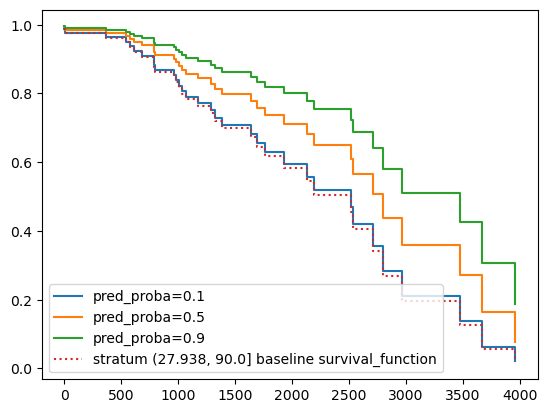

In [92]:
cph.plot_partial_effects_on_outcome(covariates = 'pred_proba', values=[0.1, 0.5, 0.9])

,breast,paper_vital_status,days_to_death,days_to_last_follow_up
barcode,,,,
TCGA-E2-A1L7-01A-11D-A145-05,0.054930,Alive,NaN,1836.0
TCGA-E2-A1LI-01A-12D-A161-05,0.475429,Alive,NaN,3121.0
TCGA-BH-A1FD-01A-11D-A13K-05,0.086495,Dead,1009.0,NaN
TCGA-BH-A0DI-01A-21D-A12R-05,0.875664,Alive,NaN,912.0
TCGA-AC-A2FG-01A-11D-A17F-05,0.794290,Alive,NaN,1853.0
...,...,...,...,...
TCGA-BH-A0DV-01A-21D-A12R-05,0.815065,Alive,NaN,2064.0
TCGA-BH-A0E1-01A-11D-A10P-05,0.039187,Alive,NaN,477.0
TCGA-A7-A0DC-01B-04D-A22R-05,0.001519,Alive,NaN,906.0


In [139]:
def plot_diff_by_category_binned(plot_data, stage_column, cancer_type, display=False, bin_edges=None):
    from itertools import combinations
    from scipy.stats import ranksums
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    # Convert stage_column to numeric, treating non-numeric values as NaN
    plot_data[stage_column] = pd.to_numeric(plot_data[stage_column], errors='coerce')
    
    # Remove rows with NaN values in the stage_column
    plot_data = plot_data.dropna(subset=[stage_column])
    
    if bin_edges is None:
        # Create default bins if not provided
        bin_edges = np.linspace(plot_data[stage_column].min(), plot_data[stage_column].max(), 6)
    
    plot_data = plot_data.sort_values(by=[stage_column])
    
    # Create a new column with binned stages
    plot_data['stage_binned'] = pd.cut(plot_data[stage_column], bins=bin_edges, include_lowest=True)
    original_column = stage_column
    stage_column = 'stage_binned'  # Use the binned column for further processing

    ordered_grades = plot_data[stage_column].cat.categories

    # Perform pairwise Wilcoxon rank-sum tests
    results = {}
    for stage1, stage2 in combinations(ordered_grades, 2):
        stage1_data = plot_data[plot_data[stage_column] == stage1][cancer_type]
        stage2_data = plot_data[plot_data[stage_column] == stage2][cancer_type]
        statistic, p_value = ranksums(stage1_data, stage2_data)
        results[(stage1, stage2)] = {'statistic': statistic, 'p_value': p_value}

    plt.figure(figsize=(12, 6))
    sns.boxplot(x=stage_column, y=cancer_type, data=plot_data, order=ordered_grades)
    plt.title(f'{cancer_type.capitalize()} Probability by {original_column}')
    plt.xlabel(original_column)
    plt.ylabel(f'{cancer_type.capitalize()} Probability')
    plt.xticks(rotation=45)

    # Add significance markers to the plot
    y_max = plot_data[cancer_type].max()
    y_range = plot_data[cancer_type].max() - plot_data[cancer_type].min()
    for i, stage1 in enumerate(ordered_grades):
        for j, stage2 in enumerate(ordered_grades[i+1:], start=i+1):
            if (stage1, stage2) in results:
                p_value = results[(stage1, stage2)]['p_value']
                if p_value < 0.001:
                    marker = '***'
                elif p_value < 0.01:
                    marker = '**'
                elif p_value < 0.05:
                    marker = '*'
                else:
                    continue  # Don't show non-significant comparisons
                y = y_max + 0.05 * y_range * (j - i)
                plt.plot([i, j], [y, y], 'k-')
                plt.text((i + j) / 2, y, marker, ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
    
    if display:
        # Print detailed results
        for (stage1, stage2), result in results.items():
            print(f"{stage1} vs {stage2}: statistic = {result['statistic']:.4f}, p-value = {result['p_value']:.4f}")

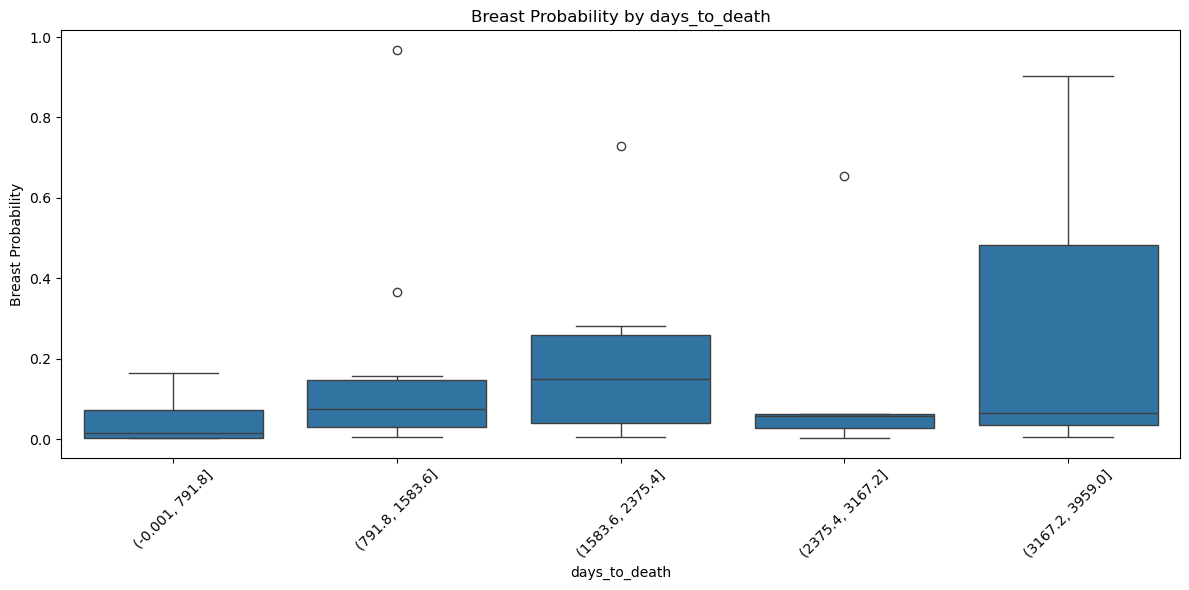

In [141]:
plot_diff_by_category_binned(brca_survival, 'days_to_death', 'breast')

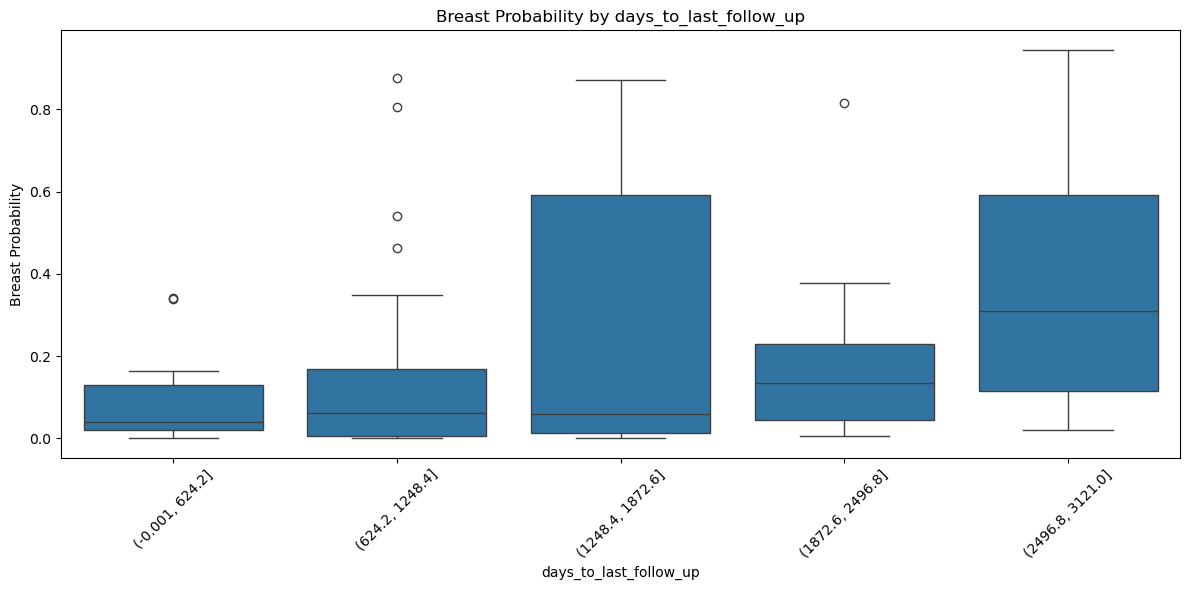

In [143]:
plot_diff_by_category_binned(brca_survival, 'days_to_last_follow_up', 'breast')

## percent cell and tumor breast probability

In [78]:
brca_meta_tumor[['sample_type','sample_submitter_id']].reset_index()

,barcode,sample_type,sample_submitter_id
0,TCGA-E2-A1L7-01A-11D-A145-05,Primary Tumor,TCGA-E2-A1L7-01A
1,TCGA-E2-A1LI-01A-12D-A161-05,Primary Tumor,TCGA-E2-A1LI-01A
2,TCGA-BH-A1FD-01A-11D-A13K-05,Primary Tumor,TCGA-BH-A1FD-01A
3,TCGA-BH-A0DI-01A-21D-A12R-05,Primary Tumor,TCGA-BH-A0DI-01A
4,TCGA-AC-A2FG-01A-11D-A17F-05,Primary Tumor,TCGA-AC-A2FG-01A
...,...,...,...
82,TCGA-BH-A0DV-01A-21D-A12R-05,Primary Tumor,TCGA-BH-A0DV-01A
83,TCGA-BH-A0E1-01A-11D-A10P-05,Primary Tumor,TCGA-BH-A0E1-01A
84,TCGA-A7-A0DC-01B-04D-A22R-05,Primary Tumor,TCGA-A7-A0DC-01B
85,TCGA-BH-A0C0-01A-21D-A10P-05,Primary Tumor,TCGA-BH-A0C0-01A


In [79]:
percent_merged = pd.merge(brca_meta_tumor[['sample_type','sample_submitter_id']].reset_index(), percent_cells[['percent_normal_cells','percent_tumor_cells','percent_tumor_nuclei','percent_lymphocyte_infiltration']], left_on='sample_submitter_id', right_on='bcr_sample_barcode')

In [81]:
percent_merged = pd.merge(brca_proba_paired['breast'].reset_index(), percent_merged, on='barcode')

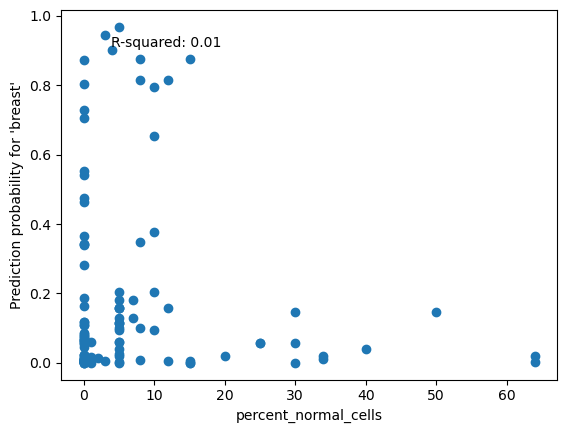

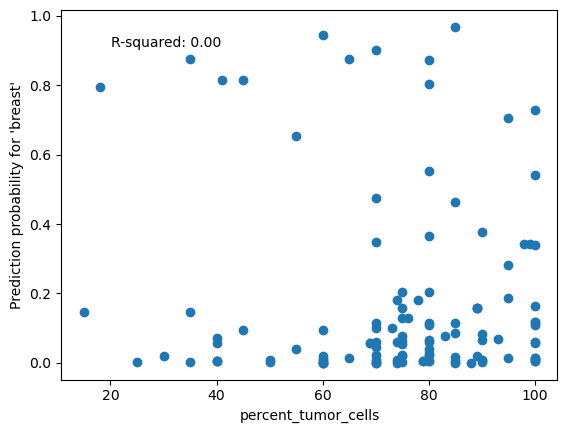

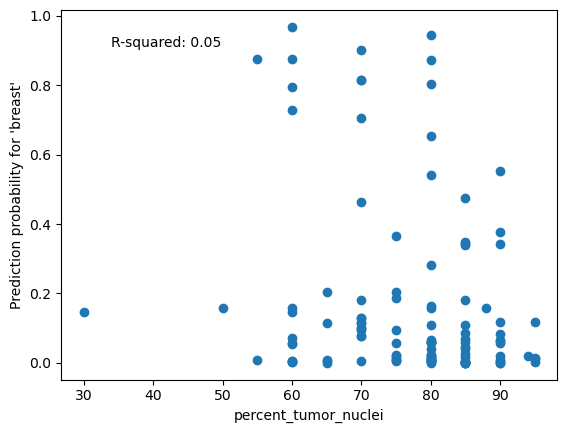

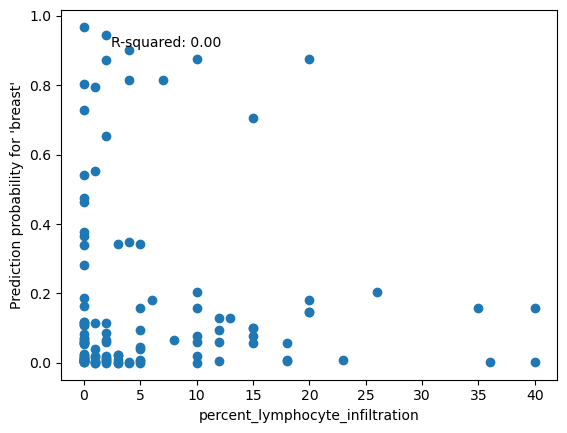

In [92]:
from sklearn.linear_model import LinearRegression
for percent_col in ['percent_normal_cells','percent_tumor_cells','percent_tumor_nuclei','percent_lymphocyte_infiltration']:
    x = percent_merged[percent_col].values
    y = percent_merged['breast'].values
    
    plt.figure()
    plt.scatter(x=x,y=y)
    plt.ylabel(f"Prediction probability for 'breast'")
    plt.xlabel(percent_col)
    
    # Fit linear regression model
    model = LinearRegression().fit(x.reshape(-1, 1), y)
    r_squared = model.score(x.reshape(-1, 1), y)

    # Add R-squared to plot
    plt.text(0.1, 0.9, f'R-squared: {r_squared:.2f}', transform=plt.gca().transAxes)


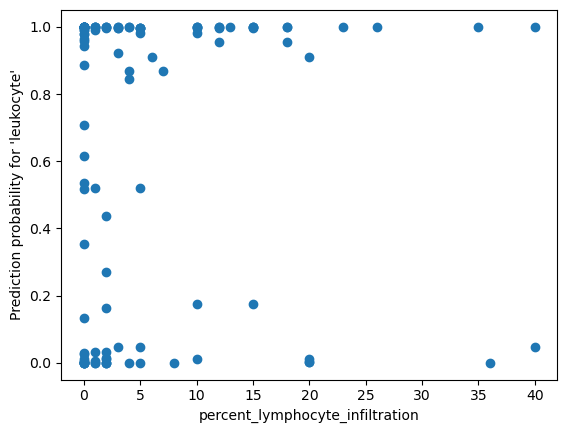

In [121]:
tissue = 'leukocyte'
percent_merged = pd.merge(brca_meta_tumor[['sample_type','sample_submitter_id']].reset_index(), percent_cells[['percent_normal_cells','percent_tumor_cells','percent_tumor_nuclei','percent_lymphocyte_infiltration']], left_on='sample_submitter_id', right_on='bcr_sample_barcode')
percent_merged = pd.merge(brca_proba_paired[tissue].reset_index(), percent_merged, on='barcode')

from sklearn.linear_model import LinearRegression
for percent_col in ['percent_lymphocyte_infiltration']:
    x = percent_merged[percent_col].values
    y = percent_merged[tissue].values
    
    plt.figure()
    plt.scatter(x=x,y=y)
    plt.ylabel(f"Prediction probability for '{tissue}'")
    plt.xlabel(percent_col)
    
#     # Fit linear regression model
#     model = LinearRegression().fit(x.reshape(-1, 1), y)
#     r_squared = model.score(x.reshape(-1, 1), y)

#     # Add R-squared to plot
#     plt.text(0.8, 0.9, f'R-squared: {r_squared:.2f}', transform=plt.gca().transAxes)


## sankey

In [66]:
class SankeyNode:
    def __init__(self, name, x_position):
        self.name = name
        self.x_position = x_position
        self.length = 0 
    def __repr__(self):
        return f"({self.name}, {self.x_position})"
    def increment(self):
        self.length += 1
        # print(self)

class SankeyLink:
    def __init__(self, source, target, value):
        self.source = source
        self.target = target
        self.value = value
    def __repr__(self):
        return f"({self.source}, {self.target}, {self.value})"

class SankeyDiagram:
    def __init__(self, cancer_pred_name_paired, cancer_meta_paired):
        self.cancer_pred_name_paired = cancer_pred_name_paired
        self.cancer_meta_paired = cancer_meta_paired
        self.nodes = []
        self.links = []
        self.option = "Metastatic"
        self.relevant_barcodes = []
        self.relevant_patients = []
        self.process_data()

    def add_node(self, name, x_position):
        node = SankeyNode(name, x_position)
        self.nodes.append(node)
        return node

    def add_link(self, source, target, value):
        self.links.append(SankeyLink(source, target, value))
        
    def add_barcode(self, b1, b2):
        self.relevant_barcodes.append(b1)
        self.relevant_barcodes.append(b2)
        
    def add_patient(self, p):
        self.relevant_patients.append(p)

    def process_data(self):
        # Filter data by sample type
        solid_tissue_normal = self.cancer_meta_paired[self.cancer_meta_paired['sample_type'] == "Solid Tissue Normal"]
        primary_tumor = self.cancer_meta_paired[self.cancer_meta_paired['sample_type'] == "Primary Tumor"]
        metastatic = self.cancer_meta_paired[self.cancer_meta_paired['sample_type'] == "Metastatic"]
        
        if metastatic.shape[0]==0:
            metastatic = self.cancer_meta_paired[self.cancer_meta_paired['sample_type'] == "Recurrent"]
            self.option="Recurrent"
        else:
            self.option="Metastatic"
        # Process sample pairs
        self.process_sample_pairs(solid_tissue_normal, "Normal", primary_tumor, "Tumor")
        self.process_sample_pairs(solid_tissue_normal, "Normal", metastatic, self.option)
        self.process_sample_pairs(primary_tumor, "Tumor", metastatic, self.option)

    def process_sample_pairs(self, df1, type1, df2, type2):
        # Create a dictionary to store barcodes and their predictions for df1
        df1 = df1.reset_index()
        df2 = df2.reset_index()

        df1_dict = {}
        for _, row in df1.iterrows():
            barcode1 = row['barcode']
            predictions = self.get_predictions(barcode1)
            df1_dict[row['patient']] = self.create_label(type1, predictions)

        # Iterate over df2 and link with df1 if patient IDs match
        for _, row in df2.iterrows():
            barcode2 = row['barcode']
            predictions = self.get_predictions(barcode2)
            patient = row['patient']
            target_node = self.create_label(type2, predictions)
            if patient in df1_dict:
                source_node_name = df1_dict[patient]
                target_node_name = target_node

                # Find the corresponding SankeyNode objects
                source_node = next((node for node in self.nodes if node.name == source_node_name), None)
                target_node = next((node for node in self.nodes if node.name == target_node_name), None)

                # Add nodes if not already present
                if source_node is None:
                    source_node = self.add_node(source_node_name, self.get_x_position(type1))
                if target_node is None:
                    target_node = self.add_node(target_node_name, self.get_x_position(type2))

                # Add link
                self.add_link(source_node_name, target_node_name, 1)
                source_node.increment()
                target_node.increment()
                
                self.add_barcode(barcode1, barcode2)
                self.add_patient(patient)

    def get_predictions(self, barcode):
        return tuple(self.cancer_pred_name_paired.get(barcode, ('no prediction',)))

    def create_label(self, sample_type, predictions):
        return f"{sample_type}: {predictions}"

    def get_x_position(self, sample_type):
        if sample_type == "Normal":
            return 0.1
        elif sample_type == "Tumor":
            return 0.5
        elif sample_type == "Metastatic" or sample_type == "Recurrent":
            return 0.9

    def create_diagram(self, output_file):
        node_names = [node.name for node in self.nodes]
        node_dict = {name: i for i, name in enumerate(node_names)}
        padding=10
        
        x_positions = []
        y_positions = []

        normal_nodes = [n for n in self.nodes if "Normal" in n.name]
        normal_length_all = sum([n.length for n in normal_nodes]) + padding*(len(normal_nodes)-1)

        tumor_nodes = [n for n in self.nodes if "Tumor" in n.name]
        tumor_length_all = sum([n.length for n in tumor_nodes]) + padding*(len(tumor_nodes)-1)

        metastatic_nodes = [n for n in self.nodes if (self.option in n.name)]
        metastatic_length_all = sum([n.length for n in metastatic_nodes]) + padding*(len(metastatic_nodes)-1)

        normal_y = normal_length_all/2 + padding
        tumor_y = tumor_length_all/2 + padding
        metastatic_y = metastatic_length_all/2 + padding
        
        # normal_y = tumor_y = metastatic_y = 0

        for node in self.nodes:
            if "Normal" in node.name:
                x_positions.append(0.1)
                y_positions.append(normal_y)
                normal_y -= (node.length + padding)
                # print(node.name, node.length, x_positions[-1], y_positions[-1])
            elif "Tumor" in node.name:
                x_positions.append(0.5)
                y_positions.append(tumor_y)
                tumor_y -= (node.length + padding)
                # print(node.name, node.length, x_positions[-1], y_positions[-1])
            else:  # Metastatic
                x_positions.append(0.9)
                y_positions.append(metastatic_y)
                metastatic_y -= (node.length + padding)
                # print(node.name, node.length, x_positions[-1], y_positions[-1])

        # Scale y-positions to fit the figure
        y_min = min(y_positions)
        y_max = max(y_positions)
        y_positions = [(y - y_min) / (y_max - y_min) for y in y_positions]

        # Use the adjusted x-positions and y-positions
        fig = go.Figure(data=[go.Sankey(
            # arrangement = "snap",
            node=dict(
                pad=padding,
                thickness=10,
                line=dict(color="black", width=0.5),
                label=node_names,
                # x=x_positions,
                # y=y_positions
            ),
            link=dict(
                source=[node_dict[link.source] for link in self.links],
                target=[node_dict[link.target] for link in self.links],
                value=[link.value for link in self.links]
            )
        )])

        fig.update_layout(
            autosize=True,
            # height=120,
            # width=80,
            # margin=dict(
            #     l=500,
            #     r=500,
            #     b=500,
            #     t=50,
            #     pad=4
            # )
        )
        fig.write_image(f"{output_file}.pdf", width=800, height=1200, scale=0.5)

In [67]:
brca_sankey = SankeyDiagram(brca_pred_name.loc[brca_meta_paired.index], brca_meta_paired)
brca_sankey.create_diagram(f"sankey_{cancer_type}_paired")

# TCGA - PAAD

In [85]:
cancer_type = 'PAAD'

In [86]:
paad_Mv, paad_meta = get_TCGA_data(195, cancer_type)

In [ ]:
paad_meta.columns

In [ ]:
paad_Mv_imputed = scale(impute_chromosome_neighbors(mapping_all, paad_Mv, minipatch_probes))

In [ ]:
paad_pred_name, paad_pred_proba = predict_and_report_TCGA(paad_Mv_imputed[minipatch_probes], paad_meta, clf, 'pancreas')

## summarize and visualize predicted labels

In [ ]:
paad_summary = summarize_predicted_labels(paad_pred_name, paad_meta, cancer_type)

## paired

In [40]:
paad_Mv_paired, paad_meta_paired = get_normal_to_tumor(paad_Mv_imputed, paad_meta)

In [ ]:
paad_pred_name_paired = predict_and_report_TCGA(paad_Mv_paired[minipatch_probes], paad_meta_paired, clf45, 'pancreas')

In [ ]:
paad_summary_paired = summarize_predicted_labels(paad_pred_name_paired, paad_meta_paired, cancer_type)

In [ ]:
visualize_paired(paad_pred_name_paired, paad_meta_paired, cancer_type)

In [44]:
class SankeyNode:
    def __init__(self, name, x_position):
        self.name = name
        self.x_position = x_position
        self.length = 0 
    def __repr__(self):
        return f"({self.name}, {self.x_position})"
    def increment(self):
        self.length += 1
        # print(self)

class SankeyLink:
    def __init__(self, source, target, value):
        self.source = source
        self.target = target
        self.value = value
    def __repr__(self):
        return f"({self.source}, {self.target}, {self.value})"

class SankeyDiagram:
    def __init__(self, cancer_pred_name_paired, cancer_meta_paired):
        self.cancer_pred_name_paired = cancer_pred_name_paired
        self.cancer_meta_paired = cancer_meta_paired
        self.nodes = []
        self.links = []
        self.option = "Metastatic"
        self.process_data()

    def add_node(self, name, x_position):
        node = SankeyNode(name, x_position)
        self.nodes.append(node)
        return node

    def add_link(self, source, target, value):
        self.links.append(SankeyLink(source, target, value))

    def process_data(self):
        # Filter data by sample type
        solid_tissue_normal = self.cancer_meta_paired[self.cancer_meta_paired['sample_type'] == "Solid Tissue Normal"]
        primary_tumor = self.cancer_meta_paired[self.cancer_meta_paired['sample_type'] == "Primary Tumor"]
        metastatic = self.cancer_meta_paired[self.cancer_meta_paired['sample_type'] == "Metastatic"]
        
        if metastatic.shape[0]==0:
            metastatic = self.cancer_meta_paired[self.cancer_meta_paired['sample_type'] == "Recurrent"]
            self.option="Recurrent"
        else:
            self.option="Metastatic"
        # Process sample pairs
        self.process_sample_pairs(solid_tissue_normal, "Normal", primary_tumor, "Tumor")
        self.process_sample_pairs(solid_tissue_normal, "Normal", metastatic, self.option)
        self.process_sample_pairs(primary_tumor, "Tumor", metastatic, self.option)

    def process_sample_pairs(self, df1, type1, df2, type2):
        # Create a dictionary to store barcodes and their predictions for df1
        df1 = df1.reset_index()
        df2 = df2.reset_index()

        df1_dict = {}
        for _, row in df1.iterrows():
            barcode = row['barcode']
            predictions = self.get_predictions(barcode)
            df1_dict[row['patient']] = self.create_label(type1, predictions)

        # Iterate over df2 and link with df1 if patient IDs match
        for _, row in df2.iterrows():
            barcode = row['barcode']
            predictions = self.get_predictions(barcode)
            patient = row['patient']
            target_node = self.create_label(type2, predictions)
            if patient in df1_dict:
                source_node_name = df1_dict[patient]
                target_node_name = target_node

                # Find the corresponding SankeyNode objects
                source_node = next((node for node in self.nodes if node.name == source_node_name), None)
                target_node = next((node for node in self.nodes if node.name == target_node_name), None)

                # Add nodes if not already present
                if source_node is None:
                    source_node = self.add_node(source_node_name, self.get_x_position(type1))
                if target_node is None:
                    target_node = self.add_node(target_node_name, self.get_x_position(type2))

                # Add link
                self.add_link(source_node_name, target_node_name, 1)
                source_node.increment()
                target_node.increment()

    def get_predictions(self, barcode):
        return tuple(self.cancer_pred_name_paired.get(barcode, ('no prediction',)))

    def create_label(self, sample_type, predictions):
        return f"{sample_type}: {predictions}"

    def get_x_position(self, sample_type):
        if sample_type == "Normal":
            return 0.1
        elif sample_type == "Tumor":
            return 0.5
        elif sample_type == "Metastatic" or sample_type == "Recurrent":
            return 0.9

    def create_diagram(self, output_file):
        node_names = [node.name for node in self.nodes]
        node_dict = {name: i for i, name in enumerate(node_names)}
        padding=10
        
        x_positions = []
        y_positions = []

        normal_nodes = [n for n in self.nodes if "Normal" in n.name]
        normal_length_all = sum([n.length for n in normal_nodes]) + padding*(len(normal_nodes)-1)

        tumor_nodes = [n for n in self.nodes if "Tumor" in n.name]
        tumor_length_all = sum([n.length for n in tumor_nodes]) + padding*(len(tumor_nodes)-1)

        metastatic_nodes = [n for n in self.nodes if (self.option in n.name)]
        metastatic_length_all = sum([n.length for n in metastatic_nodes]) + padding*(len(metastatic_nodes)-1)

        normal_y = normal_length_all/2 + padding
        tumor_y = tumor_length_all/2 + padding
        metastatic_y = metastatic_length_all/2 + padding
        
        # normal_y = tumor_y = metastatic_y = 0

        for node in self.nodes:
            if "Normal" in node.name:
                x_positions.append(0.1)
                y_positions.append(normal_y)
                normal_y -= (node.length + padding)
                # print(node.name, node.length, x_positions[-1], y_positions[-1])
            elif "Tumor" in node.name:
                x_positions.append(0.5)
                y_positions.append(tumor_y)
                tumor_y -= (node.length + padding)
                # print(node.name, node.length, x_positions[-1], y_positions[-1])
            else:  # Metastatic
                x_positions.append(0.9)
                y_positions.append(metastatic_y)
                metastatic_y -= (node.length + padding)
                # print(node.name, node.length, x_positions[-1], y_positions[-1])

        # Scale y-positions to fit the figure
        y_min = min(y_positions)
        y_max = max(y_positions)
        y_positions = [(y - y_min) / (y_max - y_min) for y in y_positions]

        # Use the adjusted x-positions and y-positions
        fig = go.Figure(data=[go.Sankey(
            arrangement = "snap",
            node=dict(
                pad=padding,
                thickness=10,
                line=dict(color="black", width=0.5),
                label=node_names,
                # x=x_positions,
                # y=y_positions
            ),
            link=dict(
                source=[node_dict[link.source] for link in self.links],
                target=[node_dict[link.target] for link in self.links],
                value=[link.value for link in self.links]
            )
        )])

        fig.update_layout(
            autosize=True,
            height=1200,
            width=1200,
            margin=dict(
                l=10,
                r=350,
                b=500,
                t=50,
                pad=4
            )
        )
        fig.write_image(f"{output_file}.pdf", width=800, height=1200, scale=0.5)

In [45]:
paad_diagram_paired = SankeyDiagram(paad_pred_name_paired, paad_meta_paired)
paad_diagram_paired.create_diagram(f"sankey_{cancer_type}_paired")

In [46]:
paad_diagram_all = SankeyDiagram(paad_pred_name, paad_meta)
paad_diagram_all.create_diagram(f"sankey_{cancer_type}_all")

## purity

In [ ]:
estimate['Cancer type'].value_counts()

In [48]:
# plot_by_purity(paad_pred_name, paad_meta, estimate, cancer_type)

In [ ]:
[column_name for column_name in paad_meta.columns if "Purity" in column_name]

In [ ]:
# # old purity from ABSOLUTE

df = pd.DataFrame({
    'Purity': paad_meta_paired['paper_ABSOLUTE.Purity'],
    'Prediction': paad_pred_name_paired
})

# Define bin edges and labels
bin_edges = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
bin_labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0']

# Drop rows with NaN in Prediction and explode the Prediction column
df_exploded = df.dropna(subset=['Prediction']).explode('Prediction')

# Bin the Purity levels
df_exploded['Purity_Binned'] = pd.cut(df_exploded['Purity'], bins=bin_edges, labels=bin_labels, right=False)

# Group by binned Purity and Prediction to get counts
label_counts_by_purity = df_exploded.groupby(['Purity_Binned', 'Prediction']).size().reset_index(name='Count')

# Pivot the data to have binned purity levels as rows and tissues as columns
pivot_df = label_counts_by_purity.pivot(index='Purity_Binned', columns='Prediction', values='Count').fillna(0)

# Normalize the counts to proportions
pivot_df_normalized = pivot_df.div(pivot_df.sum(axis=1), axis=0)

# Plot the stacked bar chart with normalized data
colors_list = [colors.get(label, '#000000') for label in pivot_df_normalized.columns]
pivot_df_normalized.plot(kind='bar', stacked=True, figsize=(14, 8), color=colors_list)

# Set plot labels and title
plt.xlabel('Purity Level')
plt.ylabel('Proportion')
plt.title(f'{cancer_type}: Distribution of Tissues Across Binned Purity Levels (Normalized)')
plt.legend(title='Tissue Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

In [ ]:
plot_predicted_labels_vs_purity(paad_pred_name, paad_meta, 
                                pd.Series(paad_meta['paper_ABSOLUTE.Purity'].values, paad_meta['sample']),
                                'PAAD')

In [ ]:
paad_pred_name[paad_meta['sample_type']=='Primary Tumor'].value_counts()

## proba

In [ ]:
paad_proba_paired, paad_meta_paired = paired_patients(paad_pred_proba, paad_meta)
proba_swarmplot(paad_proba_paired, paad_meta_paired, 'pancreas')

In [ ]:
plot_paired_diff(paad_meta_paired, paad_proba_paired, 'pancreas', 'ajcc_pathologic_stage')

In [ ]:
plot_paired_diff(paad_meta_paired, paad_proba_paired, 'pancreas', 'gender')

In [ ]:
plot_paired_diff(paad_meta_paired, paad_proba_paired, 'pancreas', 'age_at_index')

# TCGA - LIHC

In [92]:
cancer_type = 'LIHC'

In [93]:
lihc_Mv, lihc_meta = get_TCGA_data(430, cancer_type)

In [ ]:
lihc_meta.columns

In [ ]:
lihc_Mv_imputed = scale(impute_chromosome_neighbors(mapping_all, lihc_Mv, minipatch_probes))

In [ ]:
lihc_pred_name, lihc_pred_proba = predict_and_report_TCGA(lihc_Mv_imputed[minipatch_probes], lihc_meta, clf, 'liver')

## summarize and visualize predicted labels

In [ ]:
lihc_summary = summarize_predicted_labels(lihc_pred_name, lihc_meta, cancer_type)

## paired

In [58]:
lihc_Mv_paired, lihc_meta_paired = get_normal_to_tumor(lihc_Mv_imputed, lihc_meta)

In [ ]:
lihc_pred_name_paired = predict_and_report_TCGA(lihc_Mv_paired[minipatch_probes], lihc_meta_paired, clf45, 'liver')

In [ ]:
lihc_summary_paired = summarize_predicted_labels(lihc_pred_name_paired, lihc_meta_paired, cancer_type)

In [ ]:
visualize_paired(lihc_pred_name_paired, lihc_meta_paired, cancer_type)

In [62]:
class SankeyNode:
    def __init__(self, name, x_position):
        self.name = name
        self.x_position = x_position
        self.length = 0 
    def __repr__(self):
        return f"({self.name}, {self.x_position})"
    def increment(self):
        self.length += 1
        # print(self)

class SankeyLink:
    def __init__(self, source, target, value):
        self.source = source
        self.target = target
        self.value = value
    def __repr__(self):
        return f"({self.source}, {self.target}, {self.value})"

class SankeyDiagram:
    def __init__(self, cancer_pred_name_paired, cancer_meta_paired):
        self.cancer_pred_name_paired = cancer_pred_name_paired
        self.cancer_meta_paired = cancer_meta_paired
        self.nodes = []
        self.links = []
        self.option = "Metastatic"
        self.process_data()

    def add_node(self, name, x_position):
        node = SankeyNode(name, x_position)
        self.nodes.append(node)
        return node

    def add_link(self, source, target, value):
        self.links.append(SankeyLink(source, target, value))

    def process_data(self):
        # Filter data by sample type
        solid_tissue_normal = self.cancer_meta_paired[self.cancer_meta_paired['sample_type'] == "Solid Tissue Normal"]
        primary_tumor = self.cancer_meta_paired[self.cancer_meta_paired['sample_type'] == "Primary Tumor"]
        metastatic = self.cancer_meta_paired[self.cancer_meta_paired['sample_type'] == "Metastatic"]
        
        if metastatic.shape[0]==0:
            metastatic = self.cancer_meta_paired[self.cancer_meta_paired['sample_type'] == "Recurrent"]
            self.option="Recurrent"
        else:
            self.option="Metastatic"
        # Process sample pairs
        self.process_sample_pairs(solid_tissue_normal, "Normal", primary_tumor, "Tumor")
        self.process_sample_pairs(solid_tissue_normal, "Normal", metastatic, self.option)
        self.process_sample_pairs(primary_tumor, "Tumor", metastatic, self.option)

    def process_sample_pairs(self, df1, type1, df2, type2):
        # Create a dictionary to store barcodes and their predictions for df1
        df1 = df1.reset_index()
        df2 = df2.reset_index()

        df1_dict = {}
        for _, row in df1.iterrows():
            barcode = row['barcode']
            predictions = self.get_predictions(barcode)
            df1_dict[row['patient']] = self.create_label(type1, predictions)

        # Iterate over df2 and link with df1 if patient IDs match
        for _, row in df2.iterrows():
            barcode = row['barcode']
            predictions = self.get_predictions(barcode)
            patient = row['patient']
            target_node = self.create_label(type2, predictions)
            if patient in df1_dict:
                source_node_name = df1_dict[patient]
                target_node_name = target_node

                # Find the corresponding SankeyNode objects
                source_node = next((node for node in self.nodes if node.name == source_node_name), None)
                target_node = next((node for node in self.nodes if node.name == target_node_name), None)

                # Add nodes if not already present
                if source_node is None:
                    source_node = self.add_node(source_node_name, self.get_x_position(type1))
                if target_node is None:
                    target_node = self.add_node(target_node_name, self.get_x_position(type2))

                # Add link
                self.add_link(source_node_name, target_node_name, 1)
                source_node.increment()
                target_node.increment()

    def get_predictions(self, barcode):
        return tuple(self.cancer_pred_name_paired.get(barcode, ('no prediction',)))

    def create_label(self, sample_type, predictions):
        return f"{sample_type}: {predictions}"

    def get_x_position(self, sample_type):
        if sample_type == "Normal":
            return 0.1
        elif sample_type == "Tumor":
            return 0.5
        elif sample_type == "Metastatic" or sample_type == "Recurrent":
            return 0.9

    def create_diagram(self, output_file):
        node_names = [node.name for node in self.nodes]
        node_dict = {name: i for i, name in enumerate(node_names)}
        padding=10
        
        x_positions = []
        y_positions = []

        normal_nodes = [n for n in self.nodes if "Normal" in n.name]
        normal_length_all = sum([n.length for n in normal_nodes]) + padding*(len(normal_nodes)-1)

        tumor_nodes = [n for n in self.nodes if "Tumor" in n.name]
        tumor_length_all = sum([n.length for n in tumor_nodes]) + padding*(len(tumor_nodes)-1)

        metastatic_nodes = [n for n in self.nodes if (self.option in n.name)]
        metastatic_length_all = sum([n.length for n in metastatic_nodes]) + padding*(len(metastatic_nodes)-1)

        normal_y = normal_length_all/2 + padding
        tumor_y = tumor_length_all/2 + padding
        metastatic_y = metastatic_length_all/2 + padding
        
        # normal_y = tumor_y = metastatic_y = 0

        for node in self.nodes:
            if "Normal" in node.name:
                x_positions.append(0.1)
                y_positions.append(normal_y)
                normal_y -= (node.length + padding)
                # print(node.name, node.length, x_positions[-1], y_positions[-1])
            elif "Tumor" in node.name:
                x_positions.append(0.5)
                y_positions.append(tumor_y)
                tumor_y -= (node.length + padding)
                # print(node.name, node.length, x_positions[-1], y_positions[-1])
            else:  # Metastatic
                x_positions.append(0.9)
                y_positions.append(metastatic_y)
                metastatic_y -= (node.length + padding)
                # print(node.name, node.length, x_positions[-1], y_positions[-1])

        # Scale y-positions to fit the figure
        y_min = min(y_positions)
        y_max = max(y_positions)
        y_positions = [(y - y_min) / (y_max - y_min) for y in y_positions]

        # Use the adjusted x-positions and y-positions
        fig = go.Figure(data=[go.Sankey(
            arrangement = "snap",
            node=dict(
                pad=padding,
                thickness=10,
                line=dict(color="black", width=0.5),
                label=node_names,
                # x=x_positions,
                # y=y_positions
            ),
            link=dict(
                source=[node_dict[link.source] for link in self.links],
                target=[node_dict[link.target] for link in self.links],
                value=[link.value for link in self.links]
            )
        )])

        fig.update_layout(
            autosize=True,
            height=1200,
            width=1200,
            margin=dict(
                l=10,
                r=350,
                b=500,
                t=50,
                pad=4
            )
        )
        fig.write_image(f"{output_file}.pdf", width=800, height=1200, scale=0.5)

In [63]:
lihc_diagram_paired = SankeyDiagram(lihc_pred_name_paired, lihc_meta_paired)
lihc_diagram_paired.create_diagram(f"sankey_{cancer_type}_paired")

In [64]:
lihc_diagram_all = SankeyDiagram(lihc_pred_name, lihc_meta)
lihc_diagram_all.create_diagram(f"sankey_{cancer_type}_all")

## purity

In [ ]:
plot_by_purity(lihc_pred_name_paired, lihc_meta_paired, estimate, cancer_type)

In [ ]:
plot_predicted_labels_vs_purity(lihc_pred_name, lihc_meta, estimate[estimate['Cancer type']=='LIHC']['ESTIMATE'], 'LIHC')

## proba

In [ ]:
lihc_proba_paired, lihc_meta_paired = paired_patients(lihc_pred_proba, lihc_meta)
proba_swarmplot(lihc_proba_paired, lihc_meta_paired, 'liver')

In [ ]:
plot_paired_diff(lihc_meta_paired, lihc_proba_paired, 'liver', 'ajcc_pathologic_stage')

In [ ]:
plot_paired_diff(lihc_meta_paired, lihc_proba_paired, 'liver', 'gender')

In [ ]:
plot_paired_diff(lihc_meta_paired, lihc_proba_paired, 'liver', 'age_at_index')

In [ ]:
brca_meta_paired['combined_stage'].value_counts()

## scatter by purity all

In [ ]:
cancer_data = [
    (brca_pred_name, brca_meta, estimate[estimate['Cancer type']=='BRCA']['ESTIMATE'], 'BRCA'),
    (paad_pred_name, paad_meta, pd.Series(paad_meta['paper_ABSOLUTE.Purity'].values, paad_meta['sample']),
                                'PAAD'),
    (lihc_pred_name, lihc_meta, estimate[estimate['Cancer type']=='LIHC']['ESTIMATE'], 'LIHC')
]

plot_multiple_cancers(cancer_data)

# TCGA - COAD

In [68]:
cancer_type = 'COAD'

In [69]:
coad_Mv, coad_meta = get_TCGA_data(352, cancer_type)

In [ ]:
coad_meta.sample_type.value_counts()

# Tables

In [ ]:
print("breast") 
print(brca_meta['sample_type'].value_counts())
print(len(brca_meta['patient'].unique()))

In [ ]:
print("breast all paired samples") 
print(f"number of paired samples: {len(brca_diagram_all.links)}")
# print(len(brca_meta['patient'].unique()))

In [ ]:
print("pancreas") 
print(paad_meta['sample_type'].value_counts())
print(len(paad_meta['patient'].unique()))

In [ ]:
print("pancreas all paired samples") 
print(f"number of paired samples: {len(paad_diagram_all.links)}")
# print(len(brca_meta['patient'].unique()))

In [ ]:
print("liver") 
print(lihc_meta['sample_type'].value_counts())
print(len(lihc_meta['patient'].unique()))

In [ ]:
print("liver all paired samples") 
print(f"number of paired samples: {len(lihc_diagram_all.links)}")
# print(len(brca_meta['patient'].unique()))

# TCGA - DLBC

In [277]:
cancer_type = 'DLBC'

In [278]:
dlbc_Mv, dlbc_meta = get_TCGA_data(48, cancer_type)

In [ ]:
dlbc_meta.sample_type.value_counts()

# TCGA - LAML

In [269]:
cancer_type = 'LAML'

In [270]:
laml_Mv, laml_meta = get_TCGA_data(194, cancer_type)

In [ ]:
laml_meta.sample_type.value_counts()

# TCGA - OV

In [ ]:
ov_minipatch, ov_meta = get_TCGA_data(10, 'OV')

In [ ]:
ov_pred_name = predict_and_report_TCGA(ov_minipatch, ov_meta, clf45)

## summarize and visualize predicted labels

In [ ]:
ov_summary = summarize_predicted_labels(ov_pred_name, ov_meta, 'OV')

# classification performance by inclusion

In [ ]:
def inclusion(true, pred):
    truth = np.where(true[0] == 1)[0]
    count = sum(1 for array in pred if array[truth] == 1)
    return count/len(true)

In [ ]:
sample_types = ['Primary Tumor','Metastatic','Solid Tissue Normal']
df_results = pd.DataFrame(columns=sample_types)
for sample_type in sample_types:
    print(sample_type)
    perf = list()
    for top, top_pred in top_preds.items():
        print(f"top {top}")
        type_meta = brca_meta[brca_meta['sample_type']==sample_type]
        type_pred = top_pred.loc[type_meta.index]

        true_mlb = mlb.transform([['breast']]*type_meta.shape[0])
        pred_mlb = mlb.transform(type_pred)
        
        perf+=[inclusion(true_mlb, pred_mlb)]

        # print(f"accuracy: {accuracy_score(true_mlb, pred_mlb)}")
        print(f"inclusion: {inclusion(true_mlb, pred_mlb)}")
        # print(f"precision: {precision_score(true_mlb, pred_mlb, average='samples')}")          
        
    df_results[sample_type] = perf
    # print()
df_results.index = top_preds.keys()

In [ ]:
# results = []
# sample_types = ['Primary Tumor','Metastatic','Solid Tissue Normal']

# for sample_type in sample_types:
#     print(sample_type)
#     perf = []
#     for top, top_pred in top_preds.items():
#         print(f"top {top}")
#         type_meta = brca_meta[brca_meta['sample_type'] == sample_type]
#         type_pred = top_pred.loc[type_meta.index]

#         true_mlb = mlb.transform([['breast']] * type_meta.shape[0])
#         pred_mlb = mlb.transform(type_pred)

#         accuracy = accuracy_score(true_mlb, pred_mlb)
#         inclusion_value = inclusion(true_mlb, pred_mlb)
#         precision = precision_score(true_mlb, pred_mlb, average='samples')
        
#         # Append results
#         perf.append({
#             'Top': top,
#             'Accuracy': accuracy,
#             'Inclusion': inclusion_value,
#             'Precision': precision
#         })
        
#         print(f"accuracy: {accuracy}")
#         print(f"inclusion: {inclusion_value}")
#         print(f"precision: {precision}")
#     results.append(pd.DataFrame(perf))
#     print()

# # Create dataframe
# df_results = pd.concat(results, keys=sample_types)
# print(df_results.to_latex())

In [ ]:
# df_results = pd.DataFrame(df_results['Inclusion'].ravel().reshape(3,3), columns=['top1','top3','top5'], index=['Primary Tumor','Metastatic','Solid Tissue Normal'])

In [ ]:
plt.figure()
df_results.T.plot.bar()
plt.ylabel('\"breast\" in predicted label set')
plt.xlabel('Tumor stage')
plt.xticks(rotation=45, ha='right')
plt.legend(['top1','top3','top5'])
plt.show()

In [ ]:
print(df_results.to_latex())

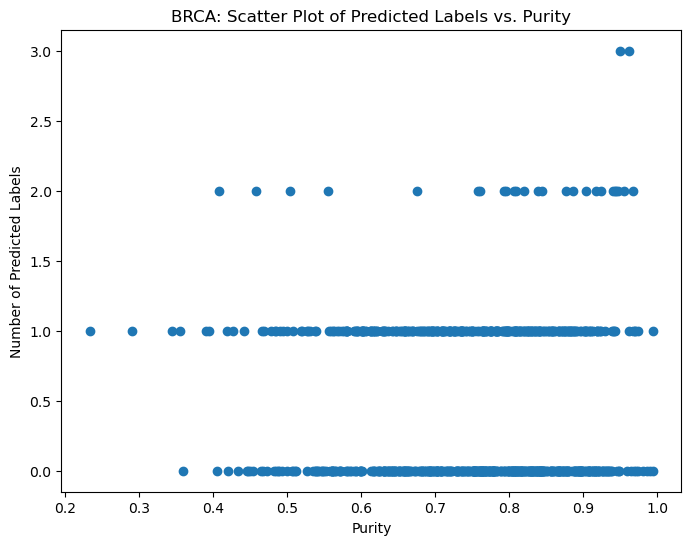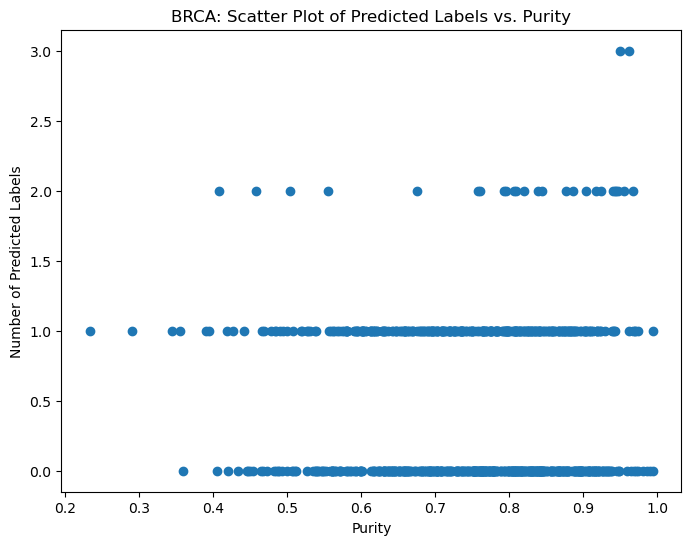# get stage info

In [ ]:
stages = pd.read_csv('/grain/wl61/github/cancer_microbiome/data/metadata/TCGA_metadata_v2.csv', sep=',', index_col=0)

In [ ]:
brca_stages = stages[stages['project_id']=='TCGA-BRCA']

In [ ]:
brca_meta.head()

In [ ]:
brca_stages_relevant = brca_stages[brca_stages['TCGABarcode'].isin(brca_meta['barcode'].str[:-16])]

In [ ]:
brca_patient_barcodes = brca_meta['barcode'].str[:-16]

In [ ]:
brca_patient_barcodes.head()

In [ ]:
[col for col in merged_df.columns if 'stage' in col]

In [ ]:
# check if all info the same with duplicate samples

for idx, row in merged_df.iterrows():
    if len(np.unique(row['ajcc_pathologic_stage']))>1: print(idx, row)

In [ ]:
merged_df.index = merged_df['barcode']

In [ ]:
merged_df.columns

In [ ]:
barcode_to_stage = merged_df[['ajcc_pathologic_stage','sample_types']].reset_index()

In [ ]:
barcode_to_stage['sample_types'].value_counts()

In [ ]:
barcode_to_stage['ajcc_pathologic_stage'].value_counts()

In [ ]:
final_sample_type = list()
for idx, row in barcode_to_stage.iterrows():
    if row['sample_types']=='Solid Tissue Normal':
        final_sample_type+=['Solid Tissue Normal']
    else:
        final_sample_type+=[row['ajcc_pathologic_stage']]
barcode_to_stage['final_sample_type'] = final_sample_type

In [ ]:
barcode_to_stage

In [ ]:
brca_meta[['barcode_short','sample_type']]

In [ ]:
barcode_to_stage = barcode_to_stage.replace(to_replace="Primary Solid Tumor", value="Primary Tumor")

In [ ]:
final_sample_type = list() 
for idx, row in brca_meta[['barcode_short','sample_type']].iterrows():
    wanted = barcode_to_stage[barcode_to_stage['barcode']==row['barcode_short']]
    # display(wanted)
    wanted = wanted[wanted['sample_types']==row['sample_type']]
    # display(wanted)
    if wanted.shape[0]<1:
        final_sample_type+=[row['sample_type']]
        print(idx)
    else:
        final_sample_type+=[wanted['final_sample_type'].values[0]]

In [ ]:
brca_meta['final_sample_type'] = final_sample_type

In [ ]:
brca_meta.index = brca_meta['barcode']

In [ ]:
brca_meta_final

In [ ]:
brca_meta_final = brca_meta['final_sample_type'].dropna()

In [ ]:
sample_types = brca_meta_final.unique()
df_results = pd.DataFrame(columns=sample_types)
for sample_type in sample_types:
    print(sample_type)
    perf = list()
    for top, top_pred in top_preds.items():
        print(f"top {top}")
        
        type_meta = brca_meta_final[brca_meta_final==sample_type]
        type_pred = top_pred.loc[type_meta.index]

        true_mlb = mlb.transform([['breast']]*type_meta.shape[0])
        pred_mlb = mlb.transform(type_pred)
        
        perf+=[inclusion(true_mlb, pred_mlb)]

        # print(f"accuracy: {accuracy_score(true_mlb, pred_mlb)}")
        print(f"inclusion: {inclusion(true_mlb, pred_mlb)}")
        # print(f"precision: {precision_score(true_mlb, pred_mlb, average='samples')}")          
        
    df_results[sample_type] = perf
    # print()
df_results.index = top_preds.keys()

In [ ]:
len(df_results.columns)

In [ ]:
df_results

In [ ]:
column_order = list(['Solid Tissue Normal', 'Primary Tumor', 'Stage I', 'Stage IA', 'Stage IB', 'Stage II', 'Stage IIA','Stage IIB','Stage III','Stage IIIA','Stage IIIB','Stage IIIC','Stage IV','Stage X'])

X indicates that the status of a certain characteristic cannot be determined

In [ ]:
df_results = df_results[column_order]
df_results

In [ ]:
plt.figure(figsize=(5,15))
df_results.T.plot.bar(figsize=(15, 5))
plt.legend(bbox_to_anchor=(1.07, 1))
plt.ylabel('\"breast\" in predicted label set')
plt.xlabel('Tumor stage')
plt.xticks(rotation=45, ha='right')
plt.legend(['top1','top3','top5'])
plt.show()

In [ ]:
print(df_results.T.to_latex())